In [52]:
# General imports
import os
import sys
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

# Other imports
import multiprocessing
import parmap
import collections
from tqdm import tqdm

tqdm.pandas()

import json
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=60, progress_bar=True)
from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager

# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

## YAML FILES CONFIG
files = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config_clean.yaml")

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Phenotypes

## OMIM raw file

In [47]:
omim_raw = pd.read_csv('/gstock/EXOTIC/data/PHENOTYPES/mim2gene.txt', sep='\t', skiprows=4)
omim_raw.columns = ['MIM', 'Type', 'Gene_ID', 'HGNC_symbol', 'ENSG']
omim_raw = omim_raw.loc[omim_raw['Type'] == 'gene']
omim_raw = omim_raw.drop_duplicates().sort_values(by='HGNC_symbol')
omim_raw = omim_raw.dropna(subset=['HGNC_symbol'])
omim_raw

,MIM,Type,Gene_ID,HGNC_symbol,ENSG
1689,138670,gene,1.0,A1BG,ENSG00000121410
26052,618199,gene,29974.0,A1CF,ENSG00000148584
152,103950,gene,2.0,A2M,ENSG00000175899
18484,610627,gene,144568.0,A2ML1,ENSG00000166535
15779,607922,gene,53947.0,A4GALT,ENSG00000128274
...,...,...,...,...,...
6501,300236,gene,158586.0,ZXDB,ENSG00000198455
23601,615746,gene,79364.0,ZXDC,ENSG00000070476
26527,618675,gene,440590.0,ZYG11A,ENSG00000203995
26525,618673,gene,79699.0,ZYG11B,ENSG00000162378


In [87]:
omim_pheno = pd.read_csv('/gstock/EXOTIC/data/PHENOTYPES/genemap2.txt', sep='\t', skiprows=3)

omim_pheno.columns = ['CHR', 'Start', 'End', 'Cyto', 'Computed_cyto', 'MIM', 'Gene_symbol', 'Gene_descr', 'Approved_symbol', 'Gene_ID', 'ENSG', 'Comments', 'Phenotype', 'Mouse_gene_ID']
omim_pheno = omim_pheno.loc[(omim_pheno['MIM'].isna() == False) & (omim_pheno['Phenotype'].isna() == False)]
omim_pheno['Phenotype'] = omim_pheno['Phenotype'].astype(str)

omim_pheno = omim_pheno.loc[(omim_pheno['ENSG'].isna() == False)]
omim_pheno['MIM'] = omim_pheno['MIM'].astype(int)
# omim_pheno['Gene_symbol'] = omim_pheno['Gene_symbol'].apply(lambda r: r.split(',')[0])
# omim_pheno = omim_pheno.loc[omim_pheno['Phenotype'].str.contains('\[')]
# omim_raw = omim_raw.loc[omim_raw['Type'] == 'gene']
# omim_raw = omim_raw.drop_duplicates().sort_values(by='HGNC_symbol')
# omim_raw = omim_raw.dropna(subset=['HGNC_symbol'])
omim_pheno

,CHR,Start,End,Cyto,Computed_cyto,MIM,Gene_symbol,Gene_descr,Approved_symbol,Gene_ID,ENSG,Comments,Phenotype,Mouse_gene_ID
22,chr1,1013496.0,1014539.0,1p36.33,1p36.33,147571,"ISG15, G1P2, IFI15, IMD38",ISG15 ubiquitin-like modifier,ISG15,9636.0,ENSG00000187608,NaN,"Immunodeficiency 38, 616126 (3), Autosomal rec...",Isg15 (MGI:1855694)
23,chr1,1020101.0,1056118.0,1pter-p32,1p36.33,103320,"AGRN, CMS8",Agrin,AGRN,375790.0,ENSG00000188157,NaN,"Myasthenic syndrome, congenital, 8, with pre- ...",Agrn (MGI:87961)
28,chr1,1211325.0,1216811.0,1p36,1p36.33,600315,"TNFRSF4, TXGP1L, OX40, ACT35, IMD16","Tumor necrosis factor receptor superfamily, me...",TNFRSF4,7293.0,ENSG00000186827,mutation identified in 1 IMD16 family,"?Immunodeficiency 16, 615593 (3), Autosomal re...",Tnfrsf4 (MGI:104512)
30,chr1,1232236.0,1235040.0,1p36.3,1p36.33,615291,"B3GALT6, SEMDJL1, EDSSPD2, ALGAZ","UDP-Gal:beta-Gal beta-1,3-galactosyltransferas...",B3GALT6,126792.0,ENSG00000176022,NaN,"Al-Gazali syndrome, 609465 (3); Ehlers-Danlos ...",B3galt6 (MGI:2152819)
36,chr1,1335277.0,1349417.0,1p36,1p36.33,601365,"DVL1, DRS2",Dishevelled segment polarity protein 1,DVL1,1855.0,ENSG00000107404,NaN,"Robinow syndrome, autosomal dominant 2, 616331...",Dvl1 (MGI:94941)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17060,chrX,155489010.0,155612951.0,Xq28,Xq28,300777,"TMLHE, BBOX2, TMLH, TMLHED, AUTSX6",Epsilon-trimethyllysine hydroxylase,TMLHE,55217.0,ENSG00000185973,NaN,"{Autism, susceptibility to, X-linked 6}, 30087...",Tmlhe (MGI:2180203)
17075,chrY,624343.0,659410.0,Ypter-p11.2,Yp11.2,400020,SHOXY,"Short stature homeo box, Y-linked",SHOX,6473.0,ENSG00000185960,pseudoautosomal,"Leri-Weill dyschondrosteosis, 127300 (3), Pseu...",NaN
17084,chrY,2786854.0,2787681.0,Yp11.3,Yp11.2,480000,"SRY, TDF, TDY, SRXX1, SRXY1",Sex-determining region Y (testis determining f...,SRY,6736.0,ENSG00000184895,NaN,"46XY sex reversal 1, 400044 (3), Y-linked; 46X...",NaN
17090,chrY,6908593.0,7107153.0,Yp11.2,Yp11.2,400033,"TBL1Y, DFNY2","Transducin-beta-like 1, Y-linked",TBL1Y,90665.0,ENSG00000092377,mutation identified in 1 DFNY2 family,"?Deafness, Y-linked 2, 400047 (3), Y-linked",NaN


In [73]:
omim_pheno.ENSG.nunique()

4309

## Processed phenotypes through API

In [525]:
from Phenotypes import omim_associations_exotic
omim = omim_associations_exotic.load_omim(files["EXOTIC"]["omim_detailed"], files["BIOMART"]["biomart_omim"])
# omim.head()
omim

,ensg,Name,OMIM,Pheno_OMIM,Pheno_Name,Pheno_prefered_title,PMID,OMIM_BP,OMIM_BP_phenotypes
0,ENSG00000274891,TRAPPC12,614139,617669,"Encephalopathy, progressive, early-onset, with...","ENCEPHALOPATHY, PROGRESSIVE, EARLY-ONSET, WITH...",[28777934],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
1,ENSG00000171853,TRAPPC12,614139,617669,"Encephalopathy, progressive, early-onset, with...","ENCEPHALOPATHY, PROGRESSIVE, EARLY-ONSET, WITH...",[28777934],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
2,ENSG00000282650,MEIOB,617670,617706,?Spermatogenic failure 22,SPERMATOGENIC FAILURE 22; SPGF22,[28206990],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
3,ENSG00000162039,MEIOB,617670,617706,?Spermatogenic failure 22,SPERMATOGENIC FAILURE 22; SPGF22,[28206990],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
4,ENSG00000277603,TPO,606765,274500,Thyroid dyshormonogenesis 2A,THYROID DYSHORMONOGENESIS 2A; TDH2A,"[1401057, 4189569, 1339470, 11061528, 8027236,...",inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
...,...,...,...,...,...,...,...,...,...
264340,ENSG00000164867,NOS3,163729,189800,"{Hypertension, pregnancy-induced}",PREECLAMPSIA/ECLAMPSIA 1; PEE1,"[6102633, 2901618, 2242360, 9311740, 10441346,...",prenatalManifestationsMaternal,['Maternal hypertension (after 20th week gesta...
264469,ENSG00000171759,PAH,612349,261600,"[Hyperphenylalaninemia, non-PKU mild]",PHENYLKETONURIA; PKU,"[8098245, 2574153, 11035829, 5461364, 5432154,...",prenatalManifestationsMaternal,['Maternal hyperphenylalaninemia teratogenic {...
264470,ENSG00000171759,PAH,612349,261600,Phenylketonuria,PHENYLKETONURIA; PKU,"[8098245, 2574153, 11035829, 5461364, 5432154,...",prenatalManifestationsMaternal,['Maternal hyperphenylalaninemia teratogenic {...
264502,ENSG00000173218,VANGL1,610132,600145,Caudal regression syndrome,SACRAL DEFECT WITH ANTERIOR MENINGOCELE,"[5505693, 2334530, 4891160, 10631160, 13641302...",prenatalManifestationsMaternal,"['Prolonged labor {SNOMEDCT:161810005,53443007..."


In [ ]:
omim

In [524]:
omim.OMIM.nunique()

2567

## OMIM entries with multiple phenotypes & at least one rare

In [4]:
def load_omim(omim_path, biomart_omim_path):
    omim = pd.read_csv(
        omim_path,
        compression="gzip",
        sep="\t",
    )
#     return omim

    print("Total : ", omim.OMIM.nunique())
    omim = omim.dropna(subset=list(omim.columns[6:-2]), how="all")
    print("Dropna on all cols : ", omim.OMIM.nunique())

    biomart_omim = pd.read_csv(biomart_omim_path, sep="\t", compression="gzip").dropna(subset=["MIM gene accession"])
    biomart_omim["MIM gene accession"] = biomart_omim["MIM gene accession"].astype(int)
    biomart_omim = biomart_omim.rename({"MIM gene accession": "OMIM", "Gene stable ID": "ensg", "Gene name": "Name"}, axis=1)

    ## ADD Gene TO OMIM
    omim = pd.merge(biomart_omim[["ensg", "Name", "OMIM"]], omim, on="OMIM")
    print("Merge BIOMART : ", omim.OMIM.nunique())


    # MELT
    omim = omim.melt(id_vars=list(omim.columns)[:7], value_vars=list(omim.columns)[7:], var_name="OMIM_BP", value_name="OMIM_BP_phenotypes").dropna()

    return omim
omim = load_omim(files["EXOTIC"]["omim_detailed"], files["BIOMART"]["biomart_omim"])
omim

Total :  2655
Dropna on all cols :  2567
Merge BIOMART :  2567


,ensg,Name,OMIM,Pheno_OMIM,Pheno_Name,Pheno_prefered_title,PMID,OMIM_BP,OMIM_BP_phenotypes
0,ENSG00000274891,TRAPPC12,614139,617669,"Encephalopathy, progressive, early-onset, with...","ENCEPHALOPATHY, PROGRESSIVE, EARLY-ONSET, WITH...",[28777934],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
1,ENSG00000171853,TRAPPC12,614139,617669,"Encephalopathy, progressive, early-onset, with...","ENCEPHALOPATHY, PROGRESSIVE, EARLY-ONSET, WITH...",[28777934],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
2,ENSG00000282650,MEIOB,617670,617706,?Spermatogenic failure 22,SPERMATOGENIC FAILURE 22; SPGF22,[28206990],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
3,ENSG00000162039,MEIOB,617670,617706,?Spermatogenic failure 22,SPERMATOGENIC FAILURE 22; SPGF22,[28206990],inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
4,ENSG00000277603,TPO,606765,274500,Thyroid dyshormonogenesis 2A,THYROID DYSHORMONOGENESIS 2A; TDH2A,"[1401057, 4189569, 1339470, 11061528, 8027236,...",inheritance,['Autosomal recessive {SNOMEDCT:258211005} {UM...
...,...,...,...,...,...,...,...,...,...
264340,ENSG00000164867,NOS3,163729,189800,"{Hypertension, pregnancy-induced}",PREECLAMPSIA/ECLAMPSIA 1; PEE1,"[6102633, 2901618, 2242360, 9311740, 10441346,...",prenatalManifestationsMaternal,['Maternal hypertension (after 20th week gesta...
264469,ENSG00000171759,PAH,612349,261600,"[Hyperphenylalaninemia, non-PKU mild]",PHENYLKETONURIA; PKU,"[8098245, 2574153, 11035829, 5461364, 5432154,...",prenatalManifestationsMaternal,['Maternal hyperphenylalaninemia teratogenic {...
264470,ENSG00000171759,PAH,612349,261600,Phenylketonuria,PHENYLKETONURIA; PKU,"[8098245, 2574153, 11035829, 5461364, 5432154,...",prenatalManifestationsMaternal,['Maternal hyperphenylalaninemia teratogenic {...
264502,ENSG00000173218,VANGL1,610132,600145,Caudal regression syndrome,SACRAL DEFECT WITH ANTERIOR MENINGOCELE,"[5505693, 2334530, 4891160, 10631160, 13641302...",prenatalManifestationsMaternal,"['Prolonged labor {SNOMEDCT:161810005,53443007..."


In [5]:
l = list()
for gene in tqdm(omim.Name.unique()):

    gene_omim = omim.loc[omim['Name'] == gene]
    if gene_omim.Pheno_OMIM.nunique() > 1:
#         print(gene, gene_omim.shape[0])
        gene_omim_bp = gene_omim[['Name', 'Pheno_OMIM', 'OMIM_BP']].groupby(['Name', 'Pheno_OMIM'])['OMIM_BP'].apply(set).reset_index()
        counter_pheno = collections.Counter([sub_e for e in gene_omim_bp['OMIM_BP'].values.tolist() for sub_e in e])
        counter_pheno_rare = [k for k,v in counter_pheno.items() if v == 1]
        l.append(gene_omim.loc[gene_omim['OMIM_BP'].isin(counter_pheno_rare)])
        
#         for pheno_rare in counter_pheno_rare:
#             print(gene_omim.loc[gene_omim['OMIM_BP'] == pheno_rare, ['Pheno_OMIM', 'Pheno_prefered_title', 'OMIM_BP', 'OMIM_BP_phenotypes']].values.tolist())
omim_multi_pheno_filterred = pd.concat(l)
omim_multi_pheno_filterred

100%|██████████| 2570/2570 [00:08<00:00, 318.55it/s]


,ensg,Name,OMIM,Pheno_OMIM,Pheno_Name,Pheno_prefered_title,PMID,OMIM_BP,OMIM_BP_phenotypes
66248,ENSG00000281289,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",laboratoryAbnormalities,['Normal or low cholesterol']
66251,ENSG00000160285,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",laboratoryAbnormalities,['Normal or low cholesterol']
78668,ENSG00000281289,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
78671,ENSG00000160285,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
82809,ENSG00000281289,LSS,600909,616509,Cataract 44,CATARACT 44; CTRCT44,"[29016354, 16440058, 30401459, 26200341]",headAndNeckEyes,"['Cataract, congenital, severe {UMLS C4228509}..."
...,...,...,...,...,...,...,...,...,...
111767,ENSG00000077522,ACTN2,102573,618654,"Myopathy, congenital with structured cores and...","MYOPATHY, CONGENITAL, WITH STRUCTURED CORES AN...",[30701273],headAndNeckMouth,['High-arched palate {SNOMEDCT:27272007} {ICD1...
231827,ENSG00000077522,ACTN2,102573,618654,"Myopathy, congenital with structured cores and...","MYOPATHY, CONGENITAL, WITH STRUCTURED CORES AN...",[30701273],neurologicPeripheralNervousSystem,"['Hyporeflexia {SNOMEDCT:22994000,405946002} {..."
8275,ENSG00000162711,NLRP3,606416,607115,CINCA syndrome,CINCA SYNDROME; CINCA,"[12483741, 16532456, 12032915, 6847730, 129288...",growthOther,"['Growth retardation {SNOMEDCT:444896005,59576..."
82795,ENSG00000162711,NLRP3,606416,607115,CINCA syndrome,CINCA SYNDROME; CINCA,"[12483741, 16532456, 12032915, 6847730, 129288...",headAndNeckHead,['Frontal bossing {SNOMEDCT:90145001} {UMLS C0...


In [534]:
omim_multi_pheno_filterred.loc[(omim_multi_pheno_filterred['Name'] == 'NF1') & (omim_multi_pheno_filterred['OMIM_BP'] == 'genitourinaryInternalGenitaliaMale'), 'OMIM_BP_phenotypes'].values.tolist()[0]

"['Cryptorchidism {SNOMEDCT:204878001} {ICD10CM:Q53.9} {ICD9CM:752.51} {UMLS C0010417 HP:0000028} {HPO HP:0000028 C0010417}']"

In [539]:
omim_multi_pheno_filterred.loc[(omim_multi_pheno_filterred['Name'] == 'NF1'), 'OMIM_BP_phenotypes'].values.tolist()[4]

"['Juvenile myelomonocytic leukemia {SNOMEDCT:128832006,445227008,277587001} {ICD10CM:C93.3,C93.30} {UMLS C0349639 HP:0012209} {HPO HP:0012209 C0349639}']"

In [542]:
omim_multi_pheno_filterred.Name.nunique()

579

In [14]:
for col in ['ensg', 'Name', 'OMIM']:
    print(col, omim[col].nunique())

ensg 2846
Name 2570
OMIM 2567


## EXOTIC imports

In [7]:
exotic = pd.read_parquet(files["EXOTIC"]["exotic_modified_zscore"])
exotic[['Exon_start', 'Exon_stop']] = exotic['Exon'].str.split('-', expand=True)
# exotic_up = omim_associations_exotic.load_exotic(files["EXOTIC"]["exotic_modified_zscore"], 'up', cutoff=0.5)
# exotic_down = omim_associations_exotic.load_exotic(files["EXOTIC"]["exotic_modified_zscore"], 'down', cutoff=0.5)

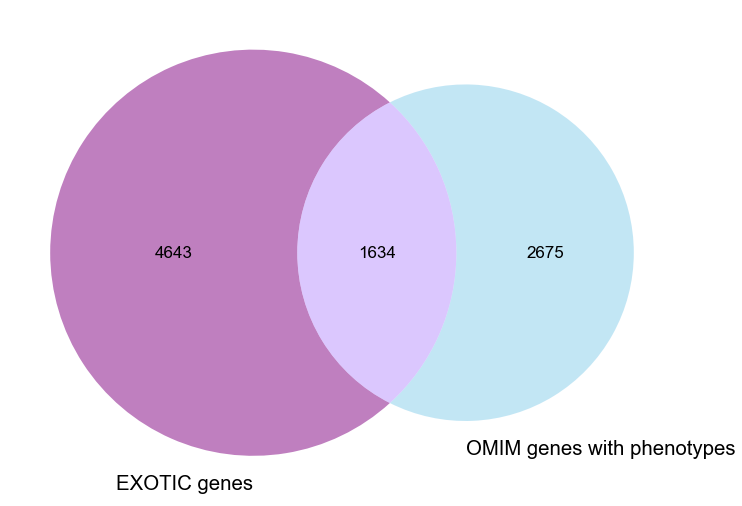

In [203]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn2([set(exotic.symbol.unique().tolist()), set(omim_pheno.Approved_symbol.unique().tolist())], set_labels=['EXOTIC genes', 'OMIM genes with phenotypes'], set_colors=['purple', 'skyblue'], alpha=0.5)


In [32]:
omim

,OMIM,Pheno_OMIM,Pheno_Name,Pheno_prefered_title,PMID,inheritance,growthOther,respiratoryNasopharynx,respiratoryAirways,respiratoryLung,...,prenatalManifestationsMovement,neurologicPeripheralNervousSystem,prenatalManifestationsPlacentaAndUmbilicalCord,respiratoryLarynx,voice,genitourinaryExternalGenitaliaFemale,prenatalManifestationsDelivery,chestDiaphragm,skinNailsHairSkinElectronMicroscopy,prenatalManifestationsMaternal
0,608958,102700,"Adenosine deaminase deficiency, partial","SEVERE COMBINED IMMUNODEFICIENCY, AUTOSOMAL RE...","[3456164, 7371221, 19179314, 12089448, 3475710...",['Autosomal recessive {SNOMEDCT:258211005} {UM...,"['Failure to thrive {SNOMEDCT:433476000,432788...",['Sinusitis {SNOMEDCT:36971009} {ICD10CM:J32} ...,['Asthma {SNOMEDCT:195967001} {ICD10CM:J45.909...,['Pneumonia {SNOMEDCT:233604007} {UMLS C003228...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,608958,102700,Severe combined immunodeficiency due to ADA de...,"SEVERE COMBINED IMMUNODEFICIENCY, AUTOSOMAL RE...","[3456164, 7371221, 19179314, 12089448, 3475710...",['Autosomal recessive {SNOMEDCT:258211005} {UM...,"['Failure to thrive {SNOMEDCT:433476000,432788...",['Sinusitis {SNOMEDCT:36971009} {ICD10CM:J32} ...,['Asthma {SNOMEDCT:195967001} {ICD10CM:J45.909...,['Pneumonia {SNOMEDCT:233604007} {UMLS C003228...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,146920,615010,Aicardi-Goutieres syndrome 6,AICARDI-GOUTIERES SYNDROME 6; AGS6,"[25243380, 24262145, 23001123]",['Autosomal recessive {SNOMEDCT:258211005} {UM...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300231,300243,"Mental retardation, X-linked syndromic, Christ...","MENTAL RETARDATION, X-LINKED, SYNDROMIC, CHRIS...","[10528855, 19471312, 20395263, 18342287, 27256...",['X-linked dominant {UMLS C1847879 HP:0001423}...,"['Developmental delay {SNOMEDCT:248290002,2249...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114020,618929,"Agenesis of corpus callosum, cardiac, ocular, ...","AGENESIS OF CORPUS CALLOSUM, CARDIAC, OCULAR, ...","[31585109, 31650526, 18798333, 30796522]","['Autosomal dominant {SNOMEDCT:771269000,26368...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,192090,137215,"Gastric cancer, hereditary diffuse, with or wi...","GASTRIC CANCER, HEREDITARY DIFFUSE; HDGC","[23709761, 15235021, 10593993, 7479380, 114436...","['Autosomal dominant {SNOMEDCT:771269000,26368...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948,192090,167000,"Ovarian cancer, somatic",OVARIAN CANCER,"[11294827, 18026186, 21720365, 12719539, 80238...",['Somatic mutation {SNOMEDCT:124975008} {UMLS ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,604878,218000,Agenesis of the corpus callosum with periphera...,AGENESIS OF THE CORPUS CALLOSUM WITH PERIPHERA...,"[589850, 8554065, 8386695, 8554070, 12838516, ...",['Autosomal recessive {SNOMEDCT:258211005} {UM...,NaN,NaN,NaN,NaN,...,NaN,"[""Peripheral motor neuropathy, severe {UMLS C1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,604272,604377,"Cardioencephalomyopathy, fatal infantile, due ...","MITOCHONDRIAL COMPLEX IV DEFICIENCY, NUCLEAR T...","[11673586, 10749987, 10545952, 15210538, 18924...",['Autosomal recessive {SNOMEDCT:258211005} {UM...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def compare_to_omim_basic_exon_level(exotic, min_max, omim, omim_detailed=True):
    print(min_max)
    print(exotic.symbol.nunique())
    print(exotic.MAP.nunique())

    mapping_omim_gtex = dicts["mapping_omim_gtex_detailed"]

    omim = omim.where(pd.notnull(omim), None)

    omim = omim.loc[~omim.duplicated(keep="last", subset=["OMIM", "Pheno_OMIM", "Pheno_prefered_title"])]

#     print(omim)

#     print(exotic)

    merge = pd.merge(omim, exotic, on="ensg")
    merge["EXOTIC_tissue_BP"] = merge["EXOTIC_tissues_above_cutoff_{}".format(min_max)].map(mapping_omim_gtex)
    merge = merge.explode("EXOTIC_tissue_BP")
    merge = merge[
        [
            "ensg",
            "symbol",
            "MAP",
            "OMIM",
            "OMIM_BP",
            "OMIM_BP_phenotypes",
            "EXOTIC_tissues_above_cutoff_{}".format(min_max),
            "EXOTIC_{}".format(min_max),
            "EXOTIC_bins_{}".format(min_max),
            "EXOTIC_tissue_BP",
        ]
    ]

#     print(merge)
    print(merge.loc[merge["OMIM_BP"] == merge["EXOTIC_tissue_BP"], 'symbol'].nunique())
    print(merge.loc[merge["OMIM_BP"] == merge["EXOTIC_tissue_BP"], 'MAP'].nunique())

In [37]:
compare_to_omim_basic_exon_level(exotic_up, 'up', omim)

up
6277
24287
460
1848


In [38]:
compare_to_omim_basic_exon_level(exotic_down, 'down', omim)

down
6277
24287
485
2215


# Clinvar

In [8]:
clinvar = pd.read_parquet(files['EXOTIC']['clinvar_file_path'])
clinvar = clinvar.loc[(clinvar['Status'] == 'Pathogenic') & (clinvar['RS_STARS'] > 0) & (clinvar['Real_Status'].str.contains('onflict') == False)]
clinvar = clinvar.loc[clinvar['OMIM_VARIANT_ID'] != ""]
clinvar

,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,OMIM_VARIANT_ID
1117,DVL1,1_1273425_AA_['G'],1,1273425,AA,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044833,204308,601365.0002
1124,DVL1,1_1273478_GGGGGCAGCCGGGT_['G'],1,1273478,GGGGGCAGCCGGGT,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044834,204312,601365.0001
1125,DVL1,1_1273487_CG_['C'],1,1273487,CG,['C'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044836,204313,601365.0003
1241,ATAD3A,1_1460622_T_['G'],1,1460622,T,['G'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter","[HP:0001321, HP:0006806, HP:0006910, HP:000703...",1570345942,624841,612316.0005
1246,ATAD3A,1_1464679_C_['T'],1,1464679,C,['T'],missense_variant,Pathogenic,Pathogenic/Likely_pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...",[],1057517686,227511,612316.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768657,RAB39B,X_154490227_G_['T'],X,154490227,G,['T'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],587777874,166303,300774.0003
768685,TMLHE,X_154736591_GAT_['G'],X,154736591,GAT,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],782624357,227145,300777.0005
768737,SRY,Y_2655442_A_['G'],Y,2655442,A,['G'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],104894968,24785,480000.0011
769854,MT-ND4,MT_11778_G_['A'],MT,11778,G,['A'],missense_variant,Pathogenic,Pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...","[HP:0001086, HP:0001112]",199476112,24747,516003.0001


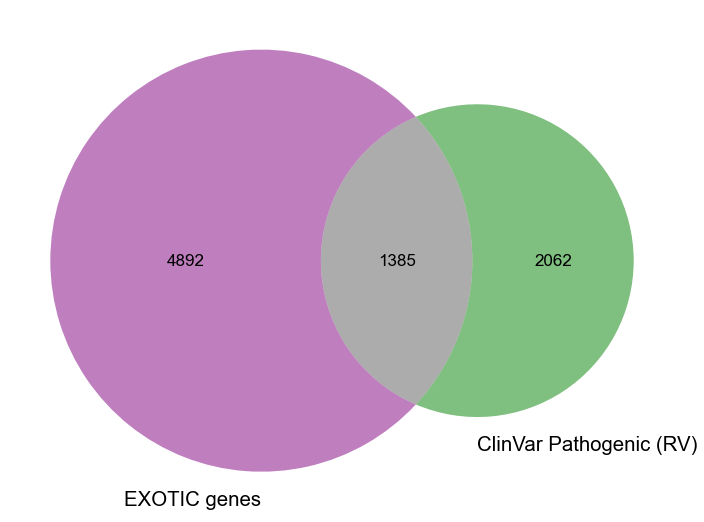

In [121]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn2([
    set(exotic.symbol.unique().tolist()), 
    set(clinvar.GENE.unique().tolist())
], 
    set_labels=['EXOTIC genes', 'ClinVar Pathogenic (RV)'], 
    set_colors=['purple', 'green'], alpha=0.5)


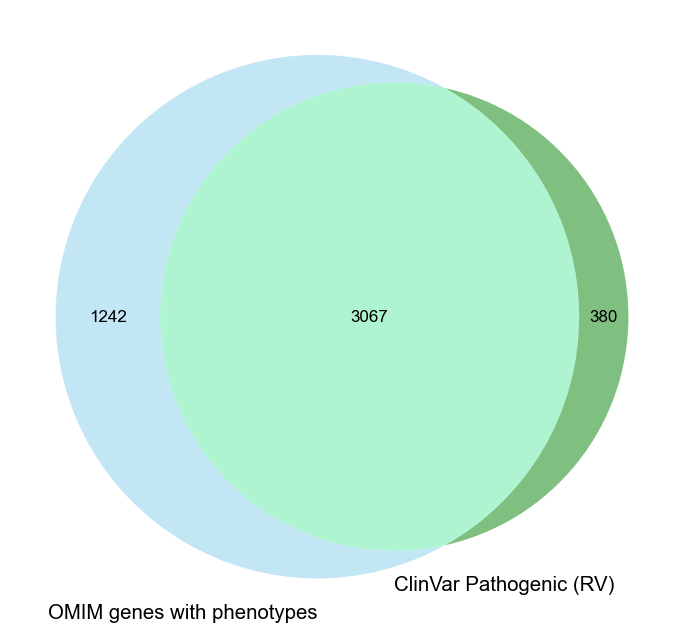

In [122]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn2([
    set(omim_pheno.Approved_symbol.unique().tolist()),
    set(clinvar.GENE.unique().tolist())
], 
    set_labels=['OMIM genes with phenotypes', 'ClinVar Pathogenic (RV)'], 
    set_colors=['skyblue', 'green'], alpha=0.5)


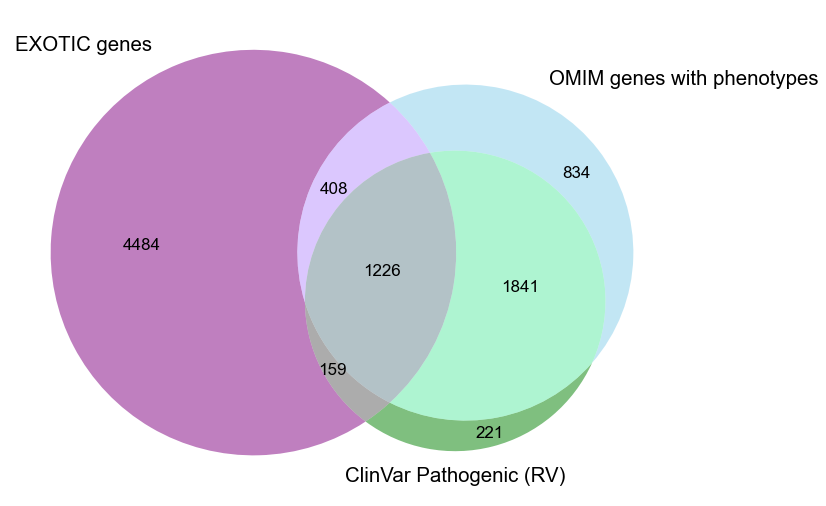

In [123]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn3([
    set(exotic.symbol.unique().tolist()), 
    set(omim_pheno.Approved_symbol.unique().tolist()),
    set(clinvar.GENE.unique().tolist())
], 
    set_labels=['EXOTIC genes', 'OMIM genes with phenotypes', 'ClinVar Pathogenic (RV)'], 
    set_colors=['purple', 'skyblue', 'green'], alpha=0.5)


In [107]:
exotic.head()

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.578349,0.441765,0.5,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.5,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.578349,0.441765,0.5,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.5,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.578349,0.441765,0.5,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.5,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.578349,0.441765,0.5,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.5,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.578349,0.441765,0.5,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."


In [208]:
clinvar.tail()

,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid
769991,MT-ND5,MT_13063_G_['A'],MT,13063,G,['A'],missense_variant,Pathogenic,Likely_pathogenic,1,"criteria_provided,_single_submitter",[],1603224017,680403
769994,MT-ND5,MT_13094_T_['C'],MT,13094,T,['C'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],1603224029,680406
770205,MT-ND6,MT_14465_G_['A'],MT,14465,G,['A'],missense_variant,Pathogenic,Likely_pathogenic,1,"criteria_provided,_single_submitter",[],1603224738,680616
770208,MT-ND6,MT_14484_T_['C'],MT,14484,T,['C'],missense_variant,Pathogenic,Pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...","[HP:0001086, HP:0001112]",199476104,24727
770210,MT-ND6,MT_14511_CTA_['C'],MT,14511,CTA,['C'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],1603224770,789102


In [ ]:
def mp_variants(gene, exotic, clinvar, l):
    exotic_tmp_gene = exotic.loc[exotic['symbol'] == gene]
    clinvar_tmp_gene = clinvar.loc[clinvar['GENE'] == gene]
    for exon in exotic_tmp_gene.Exon.unique().tolist():
        match_variants = clinvar_tmp_gene.POS.between(int(exon.split('-')[0]), int(exon.split('-')[1]))
        match_variants = clinvar_tmp_gene.loc[match_variants.loc[match_variants == True].index.tolist(), 'alleleid'].values.tolist()
        if match_variants:
            l.append({exon : match_variants})
        
# for gene in tqdm():
m = multiprocessing.Manager()
l = m.list()
genes = exotic.symbol.unique().tolist()
parmap.starmap(mp_variants, list(zip(genes)), exotic, clinvar, l, pm_pbar=True)
map_d = {k: v for d in l for k, v in d.items()}
exotic['AlleleIDs_clinvar'] = exotic['Exon'].map(map_d)
exotic_up['AlleleIDs_clinvar'] = exotic_up['Exon'].map(map_d)
exotic_down['AlleleIDs_clinvar'] = exotic_down['Exon'].map(map_d)


# print(l)

In [145]:
exotic['AlleleIDs_clinvar'] = exotic['Exon'].map(map_d)
exotic_up['AlleleIDs_clinvar'] = exotic_up['Exon'].map(map_d)
exotic_down['AlleleIDs_clinvar'] = exotic_down['Exon'].map(map_d)


In [137]:
exotic_clinvar = exotic.loc[exotic['AlleleIDs_clinvar'].isna() == False]
print(exotic_clinvar.symbol.nunique())
print(exotic_clinvar.MAP.nunique())

739
2116


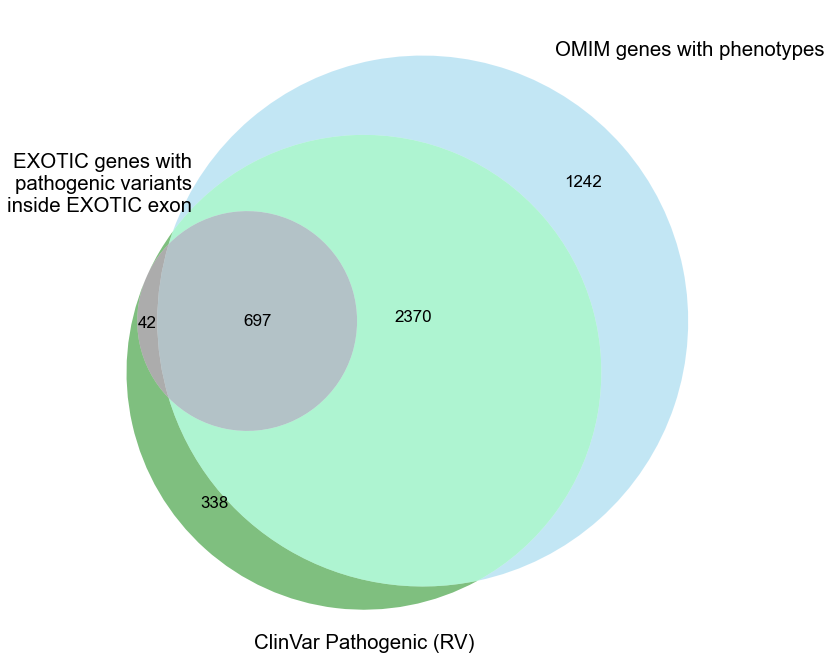

In [140]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn3([
    set(exotic_clinvar.symbol.unique().tolist()), 
    set(omim_pheno.Approved_symbol.unique().tolist()),
    set(clinvar.GENE.unique().tolist())
], 
    set_labels=['EXOTIC genes with\npathogenic variants\ninside EXOTIC exon', 'OMIM genes with phenotypes', 'ClinVar Pathogenic (RV)'], 
    set_colors=['purple', 'skyblue', 'green'], alpha=0.5)


In [156]:
exotic_up[['symbol', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index()

0.5 - 0.55    3099
0.55 - 0.6    2375
0.6 - 0.65    1610
0.65 - 0.7     922
0.7 - 0.75     621
0.75 - 0.8     386
0.8 - 0.85     276
0.85 - 0.9     185
0.9 - 0.95     134
0.95 - 1.0      79
Name: EXOTIC_bins_up, dtype: int64

In [155]:
exotic_up[['MAP', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index()

0.5 - 0.55    7777
0.55 - 0.6    6267
0.6 - 0.65    4025
0.65 - 0.7    2377
0.7 - 0.75    1551
0.75 - 0.8     803
0.8 - 0.85     538
0.85 - 0.9     456
0.9 - 0.95     255
0.95 - 1.0     244
Name: EXOTIC_bins_up, dtype: int64

In [193]:
min_max = 'up'
concat_up_stats_exotic_clinvar = pd.concat([
    exotic_up[['symbol', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_up[['MAP', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_up.loc[exotic_up['AlleleIDs_clinvar'].isna() == False][['symbol', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_up.loc[exotic_up['AlleleIDs_clinvar'].isna() == False][['MAP', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
], axis=1
)
concat_up_stats_exotic_clinvar.columns = ['EXOTIC genes', 'EXOTIC exons', 'Clinvar X EXOTIC genes', 'Clinvar X EXOTIC exons']
cols = concat_up_stats_exotic_clinvar.columns
concat_up_stats_exotic_clinvar

,EXOTIC genes,EXOTIC exons,Clinvar X EXOTIC genes,Clinvar X EXOTIC exons
0.5 - 0.55,3099,7777,312,787
0.55 - 0.6,2375,6267,222,514
0.6 - 0.65,1610,4025,158,345
0.65 - 0.7,922,2377,85,155
0.7 - 0.75,621,1551,50,103
0.75 - 0.8,386,803,29,68
0.8 - 0.85,276,538,23,51
0.85 - 0.9,185,456,14,43
0.9 - 0.95,134,255,14,42
0.95 - 1.0,79,244,5,10


(2, 10000.0)

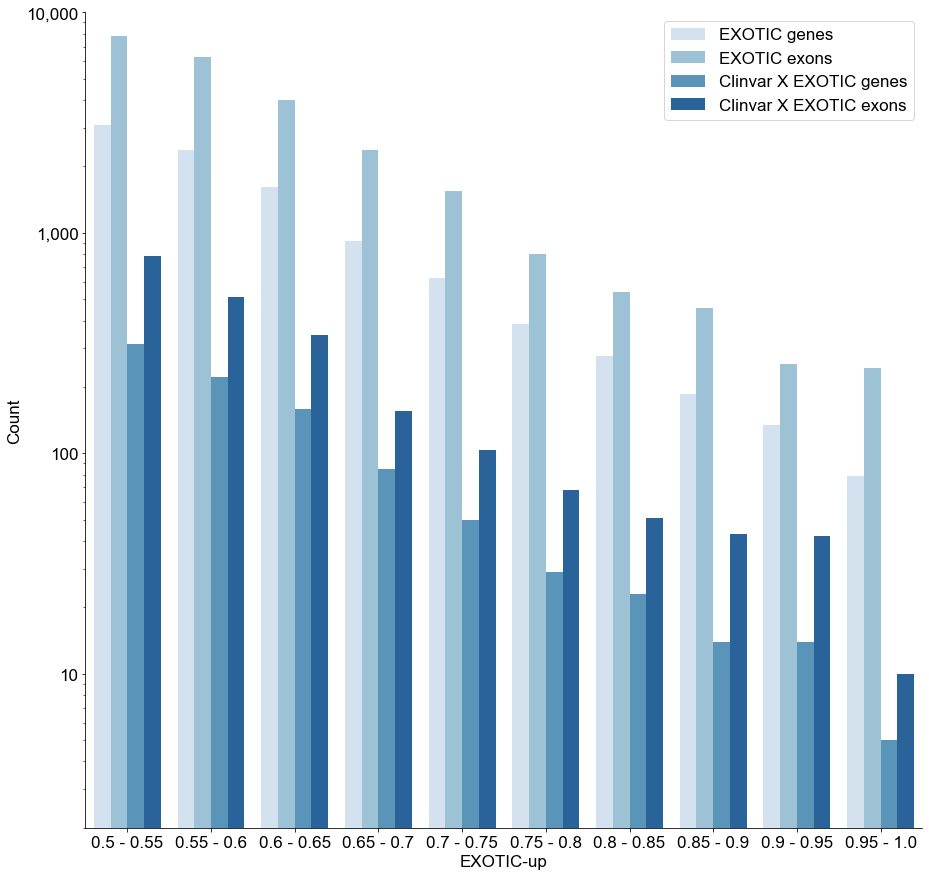

In [207]:
plt.rcParams.update({"font.size" : 17})
min_max = 'up'

f, ax = plt.subplots(figsize=(15,15))
data = concat_up_stats_exotic_clinvar.reset_index()
data.columns = ['EXOTIC_bins'] + list(cols)
data = data.melt(id_vars=['EXOTIC_bins'], value_vars=cols)
palette = ['#3C5488', '#8491BF', "#6c5ce7", "#a29bfe"]

sns.barplot(data=data, x='EXOTIC_bins', y='value', hue='variable', palette='Blues')
plt.yscale('log')
plt.legend(title='')
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
import matplotlib
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', useOffset=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Count')
ax.set_xlabel('EXOTIC-{}'.format(min_max))
ax.set_ylim(ymin=2, ymax=1e4)

In [ ]:
concat_up_stats_exotic_clinvar = concat_up_stats_exotic_clinvar.reset_index()
concat_up_stats_exotic_clinvar.columns = ['EXOTIC_bins'] + cols
concat_up_stats_exotic_clinvar = concat_up_stats_exotic_clinvar.melt(id_vars=['EXOTIC_bins'], values=cols)


sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(10,10))
data = concat_final.reset_index()
ax1_ = ax.bar(data.EXOTIC_bin_start.values, data.snpId_total.values,
#        yerr=error,
       align='edge',
       
       color='#8491B4FF',
       width=-0.020
      )
ax2 = ax.twinx()
ax2_ = ax2.bar(data.EXOTIC_bin_start.values, data.snpId.values, color='#91D1C2FF', align='edge', width=0.02)
ax.yaxis.label.set_color('#8491B4FF')
ax2.yaxis.label.set_color('#91D1C2FF')

ax.set_xticks(np.arange(min(data.EXOTIC_bin_start), max(data.EXOTIC_bin_start)+0.05, 0.05))


tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors='#8491B4FF', **tkw)
ax2.tick_params(axis='y', colors='#91D1C2FF', **tkw)
ax.set_ylabel('All sQTLs')
ax.set_xlabel('EXOTIC-max score')
ax2.set_ylabel('Tissue-specific sQTLs')
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
# plt.title('Up')

In [196]:
min_max = 'down'
concat_down_stats_exotic_clinvar = pd.concat([
    exotic_down[['symbol', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_down[['MAP', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_down.loc[exotic_down['AlleleIDs_clinvar'].isna() == False][['symbol', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
    exotic_down.loc[exotic_down['AlleleIDs_clinvar'].isna() == False][['MAP', 'EXOTIC_bins_{}'.format(min_max)]].drop_duplicates()['EXOTIC_bins_{}'.format(min_max)].value_counts().sort_index(),
], axis=1
)
concat_down_stats_exotic_clinvar.columns = ['EXOTIC genes', 'EXOTIC exons', 'Clinvar X EXOTIC genes', 'Clinvar X EXOTIC exons']
concat_down_stats_exotic_clinvar

,EXOTIC genes,EXOTIC exons,Clinvar X EXOTIC genes,Clinvar X EXOTIC exons
0.5 - 0.55,2294,5408,200,408
0.55 - 0.6,2661,7188,251,571
0.6 - 0.65,1697,4042,169,411
0.65 - 0.7,1097,2585,101,199
0.7 - 0.75,695,1494,66,122
0.75 - 0.8,504,1159,42,88
0.8 - 0.85,327,814,29,169
0.85 - 0.9,311,605,28,70
0.9 - 0.95,221,469,25,57
0.95 - 1.0,227,529,14,23


(2, 10000.0)

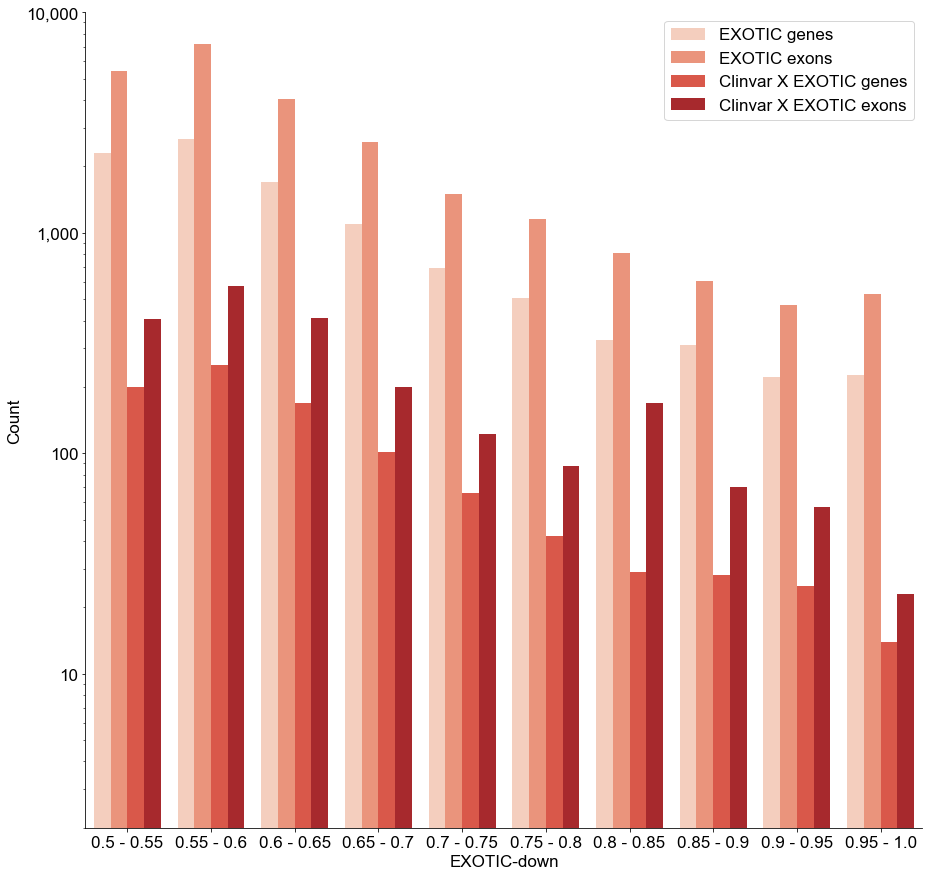

In [206]:
f, ax = plt.subplots(figsize=(15,15))
data = concat_down_stats_exotic_clinvar.reset_index()
data.columns = ['EXOTIC_bins'] + list(cols)
data = data.melt(id_vars=['EXOTIC_bins'], value_vars=cols)
palette = ['#DC0000', '#E64B35',"#fab1a0", "#fd79a8"]
min_max = 'down'

sns.barplot(data=data, x='EXOTIC_bins', y='value', hue='variable', palette='Reds')
plt.legend(title='')
plt.yscale('log')
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
import matplotlib
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', useOffset=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Count')
ax.set_xlabel('EXOTIC-{}'.format(min_max))
ax.set_ylim(ymin=2, ymax=1e4)
# ax.set_yticks()

## ClinVar PMID

In [210]:
clinvar_pmid = pd.read_csv(files['EXOTIC']['clinvar_pmid_mapping_path'], sep='\t')
clinvar_pmid

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#AlleleID,VariationID,rs,nsv,citation_source,citation_id
0,15041,2,397704705.0,NaN,PubMed,20613862
1,15046,7,200401432.0,NaN,PubMed,22072591
2,15046,7,200401432.0,NaN,PubMed,25741868
3,15046,214885,200401432.0,NaN,PubMed,19752196
4,15046,214885,200401432.0,NaN,PubMed,22826544
...,...,...,...,...,...,...
942625,969516,981436,NaN,NaN,PubMed,25741868
942626,969519,981429,NaN,NaN,PubMed,25741868
942627,969520,981416,NaN,NaN,PubMed,25741868
942628,969522,981438,NaN,NaN,PubMed,11371347


In [342]:
clinvar_pmid.loc[clinvar_pmid['#AlleleID'].isin(exotic_clinvar.explode('AlleleIDs_clinvar').AlleleIDs_clinvar.unique().tolist()), 'citation_id'].unique().tolist()

6454

In [233]:
exotic.symbol.nunique()

6277

In [339]:
exotic_clinvar.explode('AlleleIDs_clinvar')

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar,citation_id
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",8975248,8975309,608923,[31009165]
22,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,611798,[28492532]
22,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,957478,[28492532]
91,ABCC6,ENSG00000091262,57,16243990-16244098,0.666667,2,3,ABCC6_16243990-16244098,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16243990,16244098,426780,[17617515]
92,ABCC6,ENSG00000091262,57,16244435-16244629,0.666667,2,3,ABCC6_16244435-16244629,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16244435,16244629,426795,[11536079]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23988,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,789743,"[31361404, 28513610]"
23988,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,805593,"[31361404, 28513610]"
23988,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,587981,"[31361404, 28513610]"
23988,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,389091,"[31361404, 28513610]"


In [215]:
def return_pmid(r):
    l = list()
    for e in r:
        pmids = clinvar_pmid.loc[clinvar_pmid['#AlleleID'] == e, 'citation_id'].values.tolist()
        if pmids :
            l.append(pmids[0])
    return l 

exotic_clinvar['citation_id'] = exotic_clinvar.explode('AlleleIDs_clinvar').AlleleIDs_clinvar.apply(lambda r: return_pmid(r))
exotic_clinvar

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar,citation_id
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",8975248,8975309,[608923],[31009165]
22,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,"[611798, 957478]",[28492532]
91,ABCC6,ENSG00000091262,57,16243990-16244098,0.666667,2,3,ABCC6_16243990-16244098,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16243990,16244098,[426780],[17617515]
92,ABCC6,ENSG00000091262,57,16244435-16244629,0.666667,2,3,ABCC6_16244435-16244629,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16244435,16244629,[426795],[11536079]
93,ABCC6,ENSG00000091262,57,16248485-16248651,0.666667,2,3,ABCC6_16248485-16248651,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16248485,16248651,"[426807, 426810, 426811, 409463, 426813]","[11536079, 12673275, 11536079, 11536079, 12384..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23698,ZNF142,ENSG00000115568,12927,219513358-219514141,0.600000,3,5,ZNF142_219513358-219514141,0.64198,0.498250,...,0.600128,0.6 - 0.65,[Cells - EBV-transformed lymphocytes],0.580055,0.55 - 0.6,[Brain - Amygdala],219513358,219514141,"[975025, 615898]",[31036918]
23703,ZNF148,ENSG00000163848,12933,124951185-124952783,0.923077,12,13,ZNF148_124951185-124952783,0.98794,0.500000,...,0.592425,0.55 - 0.6,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",124951185,124952783,"[538354, 798521, 361750, 654123, 612636, 97509...","[25741868, 27964749, 25741868]"
23846,ZNF292,ENSG00000188994,18410,87928332-87928449,0.500000,1,2,ZNF292_87928332-87928449,0.94859,0.501500,...,0.725916,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.505250,0.5 - 0.55,[Muscle - Skeletal],87928332,87928449,[970273],[]
23938,ZNF423,ENSG00000102935,16762,49669571-49672711,0.500000,1,2,ZNF423_49669571-49672711,0.97162,0.488252,...,0.778682,0.75 - 0.8,[Testis],0.500500,0.5 - 0.55,"[Brain - Substantia nigra, Uterus]",49669571,49672711,"[264636, 677450, 409642]",[25741868]


In [476]:
exotic.loc[exotic['symbol'] == 'SPRED1']

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar


In [344]:
exotic_clinvar_exploded_variants = exotic_clinvar.explode('AlleleIDs_clinvar')
exotic_clinvar_exploded_variants = pd.merge(exotic_clinvar_exploded_variants.drop('citation_id', axis=1), clinvar_pmid[['#AlleleID', 'citation_id']], left_on='AlleleIDs_clinvar', right_on='#AlleleID').drop('#AlleleID', axis=1)

exotic_clinvar_exploded_variants

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar,citation_id
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",8975248,8975309,608923,31009165
1,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,957478,28492532
2,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,957478,26608363
3,ABCC6,ENSG00000091262,57,16243990-16244098,0.666667,2,3,ABCC6_16243990-16244098,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16243990,16244098,426780,17617515
4,ABCC6,ENSG00000091262,57,16244435-16244629,0.666667,2,3,ABCC6_16244435-16244629,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16244435,16244629,426795,11536079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21869,ZNF148,ENSG00000163848,12933,124951185-124952783,0.923077,12,13,ZNF148_124951185-124952783,0.98794,0.500000,...,0.592425,0.55 - 0.6,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",124951185,124952783,361750,27964749
21870,ZNF148,ENSG00000163848,12933,124951185-124952783,0.923077,12,13,ZNF148_124951185-124952783,0.98794,0.500000,...,0.592425,0.55 - 0.6,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",124951185,124952783,654123,25741868
21871,ZNF423,ENSG00000102935,16762,49669571-49672711,0.500000,1,2,ZNF423_49669571-49672711,0.97162,0.488252,...,0.778682,0.75 - 0.8,[Testis],0.500500,0.5 - 0.55,"[Brain - Substantia nigra, Uterus]",49669571,49672711,677450,25741868
21872,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,679595,31361404


In [345]:
exotic_clinvar_exploded_pmids = exotic_clinvar.explode('citation_id').dropna(subset=['citation_id'])
exotic_clinvar_exploded_pmids

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar,citation_id
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",8975248,8975309,[608923],31009165
22,AAGAB,ENSG00000103591,25662,67546897-67546969,0.333333,1,3,AAGAB_67546897-67546969,0.54491,0.495250,...,0.560453,0.55 - 0.6,[Artery - Aorta],0.589040,0.55 - 0.6,[Brain - Caudate (basal ganglia)],67546897,67546969,"[611798, 957478]",28492532
91,ABCC6,ENSG00000091262,57,16243990-16244098,0.666667,2,3,ABCC6_16243990-16244098,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16243990,16244098,[426780],17617515
92,ABCC6,ENSG00000091262,57,16244435-16244629,0.666667,2,3,ABCC6_16244435-16244629,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16244435,16244629,[426795],11536079
93,ABCC6,ENSG00000091262,57,16248485-16248651,0.666667,2,3,ABCC6_16248485-16248651,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16248485,16248651,"[426807, 426810, 426811, 409463, 426813]",11536079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23703,ZNF148,ENSG00000163848,12933,124951185-124952783,0.923077,12,13,ZNF148_124951185-124952783,0.98794,0.500000,...,0.592425,0.55 - 0.6,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",124951185,124952783,"[538354, 798521, 361750, 654123, 612636, 97509...",27964749
23703,ZNF148,ENSG00000163848,12933,124951185-124952783,0.923077,12,13,ZNF148_124951185-124952783,0.98794,0.500000,...,0.592425,0.55 - 0.6,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",124951185,124952783,"[538354, 798521, 361750, 654123, 612636, 97509...",25741868
23938,ZNF423,ENSG00000102935,16762,49669571-49672711,0.500000,1,2,ZNF423_49669571-49672711,0.97162,0.488252,...,0.778682,0.75 - 0.8,[Testis],0.500500,0.5 - 0.55,"[Brain - Substantia nigra, Uterus]",49669571,49672711,"[264636, 677450, 409642]",25741868
23988,ZNF462,ENSG00000148143,21684,109686414-109689445,0.500000,1,2,ZNF462_109686414-109689445,0.54621,0.496500,...,0.680485,0.65 - 0.7,[Testis],0.842905,0.8 - 0.85,[Cells - EBV-transformed lymphocytes],109686414,109689445,"[679595, 444331, 789743, 805593, 587981, 38909...",31361404


In [475]:
exotic_clinvar_exploded_pmids.loc[exotic_clinvar_exploded_pmids['symbol'] == 'SPRED1', 'citation_id'].unique()

array([], dtype=object)

In [327]:
exotic_clinvar_exploded_pmids.citation_id.nunique()

1764

In [353]:
import requests
pmid = "25264593"
pubtator_cat = "pm"
url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format(pubtator_cat, pmid)
r = requests.get(url)
j = r.json()
title = j['passages'][0]['text']
title

'Efficiency of exome sequencing for the molecular diagnosis of pseudoxanthoma elasticum.'

In [343]:
import requests

def retrieve_pmid_infos(pmid, l):
#     pmid = "31009165"
    pubtator_cat = "pm"
    url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format(pubtator_cat, pmid)
    try:
        r = requests.get(url)
        j = r.json()
        title = j['passages'][0]['text']
        abstract = j['passages'][1]['text']
        l.append({
            'citation_id' : pmid,
            'title' : title,
            'abstract' : abstract,
            }
        )
    except:
        print(pmid)

pmids = clinvar_pmid.loc[clinvar_pmid['#AlleleID'].isin(exotic_clinvar.explode('AlleleIDs_clinvar').AlleleIDs_clinvar.unique().tolist()), 'citation_id'].unique().tolist()
pmids = [e for e in pmids if 'NBK' not in e]
m = multiprocessing.Manager()
l = m.list()

parmap.starmap(retrieve_pmid_infos, list(zip(pmids)), l, pm_pbar=True)
    
pmids_infos = pd.DataFrame(list(l))
pmids_infos

  0%|          | 0/6390 [00:00<?, ?it/s]

30896912
28933811
26103414
206282012


 11%|█         | 700/6390 [00:40<05:36, 16.89it/s] 

29072892
31145570


 31%|███       | 1975/6390 [01:10<04:25, 16.65it/s]

185612205


 35%|███▍      | 2225/6390 [01:20<03:46, 18.36it/s]

31536184


 39%|███▉      | 2500/6390 [01:26<02:29, 25.97it/s]

29470032


 45%|████▍     | 2875/6390 [02:02<04:42, 12.45it/s]

125305868


 47%|████▋     | 2975/6390 [02:06<03:55, 14.50it/s]

220236128


 56%|█████▌    | 3575/6390 [02:42<02:32, 18.48it/s]

26561417


 57%|█████▋    | 3625/6390 [02:44<02:17, 20.05it/s]

168335863


 58%|█████▊    | 3675/6390 [02:48<02:57, 15.32it/s]

231588531


 59%|█████▊    | 3750/6390 [03:02<05:48,  7.57it/s]

23332917


 59%|█████▉    | 3800/6390 [03:04<04:30,  9.57it/s]

29369572


 60%|█████▉    | 3825/6390 [03:08<05:10,  8.25it/s]

29522274


 67%|██████▋   | 4275/6390 [03:22<01:47, 19.75it/s]

31536183


 69%|██████▉   | 4400/6390 [03:34<03:43,  8.89it/s]

22503188


 70%|███████   | 4475/6390 [03:44<03:49,  8.35it/s]

29594648


 84%|████████▍ | 5375/6390 [05:02<02:44,  6.18it/s]

17584774


 85%|████████▍ | 5425/6390 [05:08<02:12,  7.30it/s]

18551016


 86%|████████▌ | 5475/6390 [05:12<01:38,  9.27it/s]

25667652
29334453


 86%|████████▋ | 5525/6390 [05:20<01:50,  7.86it/s]

21537932
25264593


 87%|████████▋ | 5550/6390 [05:28<02:35,  5.40it/s]

165423944
18252223


 87%|████████▋ | 5575/6390 [05:32<02:24,  5.63it/s]

17164301


 88%|████████▊ | 5625/6390 [05:38<02:02,  6.24it/s]

22539851


 89%|████████▉ | 5675/6390 [05:44<01:42,  6.97it/s]

25082885


 89%|████████▉ | 5700/6390 [05:46<01:25,  8.04it/s]

23610110


 90%|████████▉ | 5750/6390 [05:58<01:41,  6.29it/s]

23595291


 92%|█████████▏| 5850/6390 [06:20<01:49,  4.93it/s]

12711318


 92%|█████████▏| 5875/6390 [06:38<03:04,  2.79it/s]

17351020


 95%|█████████▌| 6075/6390 [07:10<01:02,  5.04it/s]

7616128


 95%|█████████▌| 6100/6390 [07:20<01:15,  3.86it/s]

7959691


 97%|█████████▋| 6225/6390 [08:22<01:23,  1.97it/s]

19586929


100%|█████████▉| 6375/6390 [09:08<00:05,  2.54it/s]

8651289


6400it [10:22, 10.28it/s]                          


,citation_id,title,abstract
0,8673127,Spontaneous in vivo reversion to normal of an ...,Somatic mosaicism in genetic disease generally...
1,1907800,Human beta-galactosidase gene mutations in GM1...,Molecular analysis of the human beta-galactosi...
2,1353343,GM1 gangliosidosis in adults: clinical and mol...,Clinical findings were compared with the resul...
3,20945553,Perry Syndrome,CLINICAL CHARACTERISTICS: Perry syndrome is ch...
4,21667091,Bacterial expression of mutant argininosuccina...,BACKGROUND: The urea cycle defect argininosucc...
...,...,...,...
6346,9332391,Isolation and nucleotide sequence of human liv...,Glycogen storage disease type III (GSD-III) is...
6347,16525781,Polyposis and early cancer in a patient with l...,Hereditary non-polyposis colorectal cancer and...
6348,18955168,XPC initiation codon mutation in xeroderma pig...,Two unrelated xeroderma pigmentosum (XP) patie...
6349,10841810,Impaired elastic-fiber assembly by fibroblasts...,We have previously shown that intracellular tr...


In [314]:
exotic_clinvar_pmid_lite

MAP                         citation_id
A2ML1_8975248-8975309       31009165       0, , , , ,6,0,8,9,2,3,\n,N,a,m,e,:, ,(,A,2,M,L...
AAGAB_67546897-67546969     26608363       2, , , , ,9,5,7,4,7,8,\n,N,a,m,e,:, ,(,A,A,G,A...
ABCC6_16243990-16244098     17617515       3, , , , ,4,2,6,7,8,0,\n,N,a,m,e,:, ,(,A,B,C,C...
ABCC6_16244435-16244629     11536079       4, , , , ,4,2,6,7,9,5,\n,N,a,m,e,:, ,(,A,B,C,C...
ABCC6_16248485-16248651     11536079       5, , , , , ,4,2,6,8,0,7,\n,9, , , , , ,4,2,6,8...
                                                                 ...                        
ZMYND11_298288-298410       25741899       2,1,8,6,3, , , , ,2,0,5,2,6,3,\n,N,a,m,e,:, ,(...
ZNF142_219513358-219514141  31036918       2,1,8,6,7, , , , ,6,1,5,8,9,8,\n,N,a,m,e,:, ,(...
ZNF148_124951185-124952783  27964749       2,1,8,6,9, , , , ,3,6,1,7,5,0,\n,N,a,m,e,:, ,(...
ZNF462_109686414-109689445  28513610       2,1,8,7,3, , , , ,3,8,9,0,9,1,\n,N,a,m,e,:, ,(...
                            31

In [354]:
import requests

def retrieve_pmid_infos(pmid, l):
#     pmid = "31009165"
    pubtator_cat = "pm"
    url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format(pubtator_cat, pmid)
    try:
        r = requests.get(url)
        j = r.json()
        title = j['passages'][0]['text']
        abstract = j['passages'][1]['text']
        l.append({
            'citation_id' : pmid,
            'title' : title,
            'abstract' : abstract,
            }
        )
    except:
        print(pmid)

pmids = exotic_clinvar_pmid.loc[exotic_clinvar_pmid['title'].isna() == True, 'citation_id'].unique().tolist()
pmids = [e for e in pmids if 'NBK' not in e]
m = multiprocessing.Manager()
l = m.list()

parmap.starmap(retrieve_pmid_infos, list(zip(pmids)), l, pm_pbar=True)
    
pmids_infos_second = pd.DataFrame(list(l))
pmids_infos_second

  0%|          | 0/39 [00:00<?, ?it/s]

31145570231588531

28933811
16833586322023612829072892


30896912293344532936957231536184



165423944
31536183
29594648185612205206282012


125305868
26103414
29470032


100%|██████████| 39/39 [00:00<00:00, 52.67it/s]


,citation_id,title,abstract
0,22539851,Galpha(olf) mutation allows parsing the role o...,"Although L-3,4-dihydroxyphenylalanine (L-DOPA)..."
1,25264593,Efficiency of exome sequencing for the molecul...,The molecular etiology of pseudoxanthoma elast...
2,7959691,Genotype-phenotype correlation between positio...,Mutations in the adenomatous polyposis coli (A...
3,25667652,Five cases of paroxysmal kinesigenic dyskinesi...,Paroxysmal kinesigenic dyskinesia (PKD) is an ...
4,17584774,ETFDH mutations as a major cause of riboflavin...,Multiple acyl-CoA dehydrogenation deficiency (...
5,22503188,Challenges in the management of a patient with...,We would like to present a patient with a cla...
6,25082885,Molecular diagnostic testing by eyeGENE: analy...,PURPOSE: To analyze the genetic test results o...
7,17164301,Body mass index differences in pseudohypoparat...,CONTEXT: Obesity is a prominent feature of Alb...
8,7616128,Mutations in the low density lipoprotein recep...,Familial hypercholesterolemia (FH) results fro...
9,19586929,Phenotype and genotype in 17 patients with Gol...,BACKGROUND: Goltz-Gorlin syndrome or focal der...


In [355]:
pd.concat([pmids_infos, pmids_infos_second])

,citation_id,title,abstract
0,8673127,Spontaneous in vivo reversion to normal of an ...,Somatic mosaicism in genetic disease generally...
1,1907800,Human beta-galactosidase gene mutations in GM1...,Molecular analysis of the human beta-galactosi...
2,1353343,GM1 gangliosidosis in adults: clinical and mol...,Clinical findings were compared with the resul...
3,20945553,Perry Syndrome,CLINICAL CHARACTERISTICS: Perry syndrome is ch...
4,21667091,Bacterial expression of mutant argininosuccina...,BACKGROUND: The urea cycle defect argininosucc...
...,...,...,...
16,18252223,Submicroscopic duplications of the hydroxyster...,Submicroscopic copy-number imbalances contribu...
17,18551016,High prevalence of SDHB mutations in head and ...,BACKGROUND: Recent reports have found genetic ...
18,23595291,Whispering dysphonia (DYT4 dystonia) is caused...,OBJECTIVE: A study was undertaken to identify ...
19,26561417,"HRAS G13D, a new mutation implicated in the re...",


In [358]:
exotic_clinvar_pmid.columns

Index(['symbol', 'ensg', 'HGNC', 'Exon', 'Ratio_num', 'mRNA_nb',
       'mRNA_nb_total', 'MAP', 'mean_proportion', 'Adipose - Subcutaneous',
       'Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta',
       'Artery - Coronary', 'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esop

In [419]:
exotic_clinvar_pmid = pd.merge(exotic_clinvar_exploded_variants, pd.concat([pmids_infos, pmids_infos_second]), how='left', on='citation_id')
exotic_clinvar_pmid = exotic_clinvar_pmid.loc[exotic_clinvar_pmid['citation_id'].isin(citation_to_keep)]
exotic_clinvar_pmid['AlleleIDs_clinvar'] = exotic_clinvar_pmid['AlleleIDs_clinvar'].astype(str)

exotic_clinvar_pmid_lite = exotic_clinvar_pmid[['MAP', 'citation_id', 'AlleleIDs_clinvar']].groupby(['MAP', 'citation_id'])['AlleleIDs_clinvar'].apply(lambda r: ','.join(r))
exotic_clinvar_pmid_lite = exotic_clinvar_pmid_lite.reset_index().drop_duplicates()


exotic_clinvar_pmid = pd.merge(exotic_clinvar_pmid.drop(['AlleleIDs_clinvar'], axis=1).drop_duplicates(subset=['MAP', 'citation_id']), exotic_clinvar_pmid_lite, on=['MAP', 'citation_id'])

# COMPUTE BINS
r = np.arange(0.5,1.05,0.1)
bins = r
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
for min_max in ['up', 'down']:
    for j, b in enumerate(labels_ratio):
        if j > 0:
            b_start = float(b.split(' - ')[0])
            b_end = float(b.split(' - ')[1])
            print(b_start)
#             print(len(exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].columns))
#             print(exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].columns)
            if min_max == 'up':
                exotic_clinvar_pmid['EXOTIC_{}_{}'.format(b, min_max)] = exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].apply(lambda r: [exotic_clinvar_pmid.columns[9:9+53][i] for i, e in enumerate(r) if float(e) >= b_start and float(e) < b_end], axis=1)
            elif min_max == 'down':
                exotic_clinvar_pmid['EXOTIC_{}_{}'.format(b, min_max)] = exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].apply(lambda r: [exotic_clinvar_pmid.columns[9:9+53][i] for i, e in enumerate(r) if (1-float(e)) >= b_start and (1-float(e)) < b_end], axis=1)

                
exotic_clinvar_pmid['abstract'] = exotic_clinvar_pmid['abstract'].astype(str)

exotic_clinvar_pmid['Isoform_abstract'] = exotic_clinvar_pmid['abstract'].apply(lambda r: "isoform" in r.lower())
# exotic_clinvar_pmid = exotic_clinvar_pmid.loc[exotic_clinvar_pmid['Isoform_abstract'] == True]
exotic_clinvar_pmid = exotic_clinvar_pmid.loc[exotic_clinvar_pmid['symbol'] == 'NF1']


exotic_clinvar_pmid = exotic_clinvar_pmid[[
    'symbol', 'Exon', 'EXOTIC_0.6 - 0.7_up', 'EXOTIC_0.7 - 0.8_up', 'EXOTIC_0.8 - 0.9_up',
       'EXOTIC_0.9 - 1.0_up', 'EXOTIC_0.6 - 0.7_down', 'EXOTIC_0.7 - 0.8_down',
       'EXOTIC_0.8 - 0.9_down', 'EXOTIC_0.9 - 1.0_down', 'AlleleIDs_clinvar', 'citation_id', 'title', 'abstract', 'Isoform_abstract'
]]
exotic_clinvar_pmid.to_excel('/gstock/EXOTIC/data/PMIDS/NF1_EXOTIC_clinvar_PMIDS.xlsx', index=False)
exotic_clinvar_pmid


# exotic_clinvar_pmid[['symbol', 'citation_id']].drop_duplicates().symbol.value_counts()

# exotic_clinvar_pmid[['symbol', 'ensg', 'Exon', 'EXOTIC_bins_up', 'EXOTIC_tissues_up', 'EXOTIC_bins_down', 'EXOTIC_tissues_down', 'AlleleIDs_clinvar', 'citation_id', "title", 'abstract']].to_excel('/gstock/EXOTIC/data/PMIDS/EXOTIC_clinvar_PMIDS.xlsx', index=False)


0.6
0.7
0.8
0.9
0.6
0.7
0.8
0.9


,symbol,Exon,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down,AlleleIDs_clinvar,citation_id,title,abstract,Isoform_abstract
5962,NF1,29548868-29548947,[],[],[],[],[Whole Blood],[],[],[Testis],"79194,426213",10712197,Minor lesion mutational spectrum of the entire...,More than 500 unrelated patients with neurofib...,False
5963,NF1,29548868-29548947,[],[],[],[],[Whole Blood],[],[],[Testis],409863,27838393,Mutation spectrum of NF1 gene in Italian patie...,Neurofibromatosis type 1 (NF1) is caused by mu...,False
5964,NF1,29548868-29548947,[],[],[],[],[Whole Blood],[],[],[Testis],409863,16944272,Molecular diagnosis of neurofibromatosis type ...,Our experience of providing an NF1 gene diagno...,False
5965,NF1,29548868-29548947,[],[],[],[],[Whole Blood],[],[],[Testis],409863,27322474,Comprehensive RNA Analysis of the NF1 Gene in ...,BACKGROUND: The detection rate for identifying...,False
5966,NF1,29548868-29548947,[],[],[],[],[Whole Blood],[],[],[Testis],"844913,213253",16786508,The heterogeneous nature of germline mutations...,Malignant peripheral nerve sheath tumours (MPN...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,NF1,29685498-29685640,[],[],[],[],[Whole Blood],[Testis],[],[],531142,22155606,Neurofibromatosis type 1-associated tumours: t...,Somatic gene mutations constitute key events i...,False
6789,NF1,29685498-29685640,[],[],[],[],[Whole Blood],[Testis],[],[],420838,19061981,Congenital pseudarthrosis of neurofibromatosis...,Three patients with neurofibromatosis 1 (NF1) ...,False
6790,NF1,29685498-29685640,[],[],[],[],[Whole Blood],[Testis],[],[],402548,29290338,Genotype-Phenotype Correlation in NF1: Evidenc...,"Neurofibromatosis type 1 (NF1), a common genet...",False
6791,NF1,29685498-29685640,[],[],[],[],[Whole Blood],[Testis],[],[],"402548,949869",23913538,NF1 molecular characterization and neurofibrom...,Neurofibromatosis type 1 (NF1) affects about o...,False


In [357]:
exotic_clinvar_pmid.loc[exotic_clinvar_pmid['title'].isna() == True]

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,citation_id,title,abstract,AlleleIDs_clinvar
95,ACADM,ENSG00000117054,89,76198329-76198426,0.800000,4,5,ACADM_76198329-76198426,0.79607,0.499750,...,[Brain - Cerebellum],0.577373,0.55 - 0.6,[Whole Blood],76198329,76198426,NBK1424,NaN,NaN,18636
263,AGL,ENSG00000162688,321,100316599-100316680,0.666667,2,3,AGL_100316599-100316680,0.22785,0.509249,...,[Brain - Amygdala],0.793147,0.75 - 0.8,[Cells - Cultured fibroblasts],100316599,100316680,NBK26372,NaN,NaN,"16134,192258,192258"
271,AGPAT2,ENSG00000169692,325,139571037-139571132,0.500000,1,2,AGPAT2_139571037-139571132,0.90982,0.492501,...,[Spleen],0.543887,0.5 - 0.55,[Brain - Amygdala],139571037,139571132,NBK1212,NaN,NaN,359014
287,AIP,ENSG00000110711,358,67258259-67258331,0.333333,1,3,AIP_67258259-67258331,0.96979,0.500250,...,[Spleen],0.505500,0.5 - 0.55,[Muscle - Skeletal],67258259,67258331,NBK97965,NaN,NaN,49630
339,ALS2,ENSG00000003393,443,202574604-202574761,0.500000,1,2,ALS2_202574604-202574761,0.74627,0.490251,...,[Cells - EBV-transformed lymphocytes],0.590008,0.55 - 0.6,[Muscle - Skeletal],202574604,202574761,NBK1243,NaN,NaN,214531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,TTN,ENSG00000155657,12403,179391739-179392034,0.500000,1,2,TTN_179391739-179392034,0.82618,0.509499,...,[Brain - Frontal Cortex (BA9)],0.514996,0.5 - 0.55,[Cervix - Ectocervix],179391739,179392034,NBK1323,NaN,NaN,"46998,27693,27691"
9139,TTN,ENSG00000155657,12403,179410547-179410843,0.500000,1,2,TTN_179410547-179410843,0.82618,0.509499,...,[Brain - Frontal Cortex (BA9)],0.514996,0.5 - 0.55,[Cervix - Ectocervix],179410547,179410843,NBK185330,NaN,NaN,"136359,136356,136355"
9585,XPC,ENSG00000154767,12816,14197835-14197995,0.800000,4,5,XPC_14197835-14197995,0.78639,0.500000,...,[Cervix - Endocervix],0.559221,0.55 - 0.6,[Cells - EBV-transformed lymphocytes],14197835,14197995,NBK1397,NaN,NaN,262034
9608,XPC,ENSG00000154767,12816,14211938-14212050,0.800000,4,5,XPC_14211938-14212050,0.78639,0.500000,...,[Cervix - Endocervix],0.559221,0.55 - 0.6,[Cells - EBV-transformed lymphocytes],14211938,14212050,NBK1397,NaN,NaN,904910


In [335]:
exotic_clinvar_exploded_pmids.loc[exotic_clinvar_exploded_pmids['citation_id'] == "10835642"]

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_stop,AlleleIDs_clinvar,citation_id
95,ABCC6,ENSG00000091262,57,16251520-16251666,0.666667,2,3,ABCC6_16251520-16251666,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16251520,16251666,"[426846, 21602]",10835642
117,ABCC6,ENSG00000091262,57,16308181-16308306,0.666667,2,3,ABCC6_16308181-16308306,0.32334,0.486503,...,0.534445,0.5 - 0.55,[Whole Blood],0.931694,0.9 - 0.95,[Cells - EBV-transformed lymphocytes],16308181,16308306,[427068],10835642


In [415]:
exotic_clinvar_pmid.loc[exotic_clinvar_pmid['symbol'] == 'NF1', 'citation_id']

6004    16199547
6091    16513807
6273     9687500
6280    16513807
6382     9687500
6596     1783401
6661    31730495
Name: citation_id, dtype: object

In [417]:
exotic_clinvar_pmid.loc[exotic_clinvar_pmid['symbol'] == 'NF1']

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,AlleleIDs_clinvar,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down,Isoform_abstract
6004,NF1,ENSG00000196712,7765,29552113-29552268,0.666667,2,3,NF1_29552113-29552268,0.73445,0.4965,...,79199,[],[],[],[],[Whole Blood],[],[],[Testis],True
6091,NF1,ENSG00000196712,7765,29556043-29556483,0.666667,2,3,NF1_29556043-29556483,0.73445,0.4965,...,79214,[],[],[],[],[Whole Blood],[],[],[Testis],True
6273,NF1,ENSG00000196712,7765,29562629-29562790,0.666667,2,3,NF1_29562629-29562790,0.73445,0.4965,...,79232,[],[],[],[],[Whole Blood],[],[],[Testis],True
6280,NF1,ENSG00000196712,7765,29562629-29562790,0.666667,2,3,NF1_29562629-29562790,0.73445,0.4965,...,15392,[],[],[],[],[Whole Blood],[],[],[Testis],True
6382,NF1,ENSG00000196712,7765,29586050-29586147,0.666667,2,3,NF1_29586050-29586147,0.73445,0.4965,...,"478282,478190",[],[],[],[],[Whole Blood],[],[],[Testis],True
6596,NF1,ENSG00000196712,7765,29661856-29662049,0.666667,2,3,NF1_29661856-29662049,0.73445,0.4965,...,15382,[],[],[],[],[Whole Blood],[],[],[Testis],True
6661,NF1,ENSG00000196712,7765,29665722-29665823,0.666667,2,3,NF1_29665722-29665823,0.74295,0.4960,...,"184734,184734",[],[],[],[],[Whole Blood],[Testis],[],[],True


In [333]:
sorted(list(exotic_clinvar_exploded_pmids.loc[exotic_clinvar_exploded_pmids['symbol'] == 'ABCC6', 'citation_id'].unique()))

['10835642',
 '11179012',
 '11493310',
 '11536079',
 '11880368',
 '12176944',
 '12384774',
 '12673275',
 '15459974',
 '16086317',
 '16541094',
 '17617515',
 '18157818',
 '22209248',
 '25264593',
 '25741868',
 '26084751',
 '28102862',
 '30311386']

In [326]:
exotic_clinvar_pmid.citation_id.nunique()

6441

In [303]:
exotic_pmids_count = exotic_clinvar_pmid[['symbol', 'citation_id']].drop_duplicates().groupby('symbol').count().sort_values(by='citation_id', ascending=False)
exotic_pmids_count.to_excel('/gstock/EXOTIC/data/PMIDS/PMIDS_count_per_gene.xlsx')
exotic_pmids_count

,citation_id
symbol,
LDLR,316
MLH1,302
NF1,285
PTEN,214
PTPN11,177
...,...
RUNX2,1
G6PC3,1
FUS,1


In [298]:
exotic_pmids_count = exotic_clinvar_pmid[['symbol', 'citation_id']].drop_duplicates()
exotic_pmids_count

,symbol,citation_id
0,A2ML1,31009165
1,AAGAB,28492532
2,AAGAB,26608363
3,ABCC6,17617515
4,ABCC6,11536079
...,...,...
21868,ZNF148,25741868
21869,ZNF148,27964749
21871,ZNF423,25741868
21872,ZNF462,31361404


In [350]:
exotic_pmids_count = exotic_clinvar_pmid[['symbol', 'citation_id']].drop_duplicates()
d = dict(collections.Counter(exotic_pmids_count.citation_id.values.tolist()))
d = {k: d[k] for k in sorted(d, key=d.get, reverse=True)}
exotic_pmids_count = pd.DataFrame.from_dict(d, orient='index')
exotic_pmids_count.columns = ['count']
# exotic_pmids_count.to_excel('/gstock/EXOTIC/data/PMIDS/PMIDS_count_across_genes.xlsx')
# citation_to_keep = exotic_pmids_count.loc[exotic_pmids_count['count'] < 10].index.tolist()
exotic_pmids_count.head(15)




,count
25741868,375
28492532,342
24033266,68
30311386,58
26467025,49
18414213,26
25525159,15
25326635,15
25326637,14
24088041,11


In [ ]:
nf1_publis = ["10076878", "10090487", "10336779", "10494088", "10534774", "10543400", "10607834", "10677298", "10678181", "10712197", "1071297", "10721668", "10726756", "10862084", "10980545", "11137998", "11292340", "11459867", "11476066", "11735023", "11857752", "12112660", "12483293", "12522551", "125305868", "12552569", "12707950", "12746402", "12787671", "12807981", "12822827", "12872266", "14517963", "14569132", "14722917", "15060124", "15146469", "15221447", "15627836", "1568246", "1568247", "15863657", "15948193", "16005615", "16138229", "16199547", "16380919", "16479075", "16513807", "16542390", "16544997", "16773574", "16786042", "16786508", "16835897", "16870183", "16941471", "16944272", "16961930", "17103458", "17105749", "17114577", "17160901", "17209131", "17311297", "17353900", "17369502", "17426081", "17551851", "1757093", "1770531", "17712740", "17726231", "1783401", "17914445", "17960768", "18041031", "18172006", "18183640", "18484666", "18503770", "18546366", "190611", "19061981", "19117870", "19120036", "19142971", "19221814", "19292874", "19539839", "19665063", "19738042", "19845691", "19863548", "19920235", "20142468", "20602485", "20605257", "21031597", "21089071", "2114220", "21271658", "21354044", "21362601", "21532985", "21567923", "21618341", "22034633", "22041710", "22108604", "22155606", "22190595", "22207399", "22222937", "22429592", "22604720", "22664660", "22807134", "22925204", "22965773", "23010473", "23047742", "23165953", "23222849", "23244495", "23354915", "23404336", "23460398", "23583981", "23624750", "23656349", "23668869", "23758643", "23812910", "23906300", "23913538", "23954459", "24219125", "24232412", "24357598", "24413922", "24676424", "24694336", "24711935", "24789688", "24803665", "24922668", "24932921", "24951259", "25074460", "25156439", "25211147", "25240281", "25293717", "25324428", "25324867", "25325900", "25356970", "25370043", "25403449", "25480383", "25541118", "25624686", "25810463", "25877329", "25951773", "25966637", "26056819", "26076063", "26178382", "26331193", "26345759", "26458495", "26478990", "26635368", "26659639", "26706011", "26740943", "26758488", "26840085", "26908603", "26962827", "26969325", "26973730", "27069254", "27074763", "27170677", "27171602", "27322474", "27482814", "27716896", "27838393", "27862945", "27980226", "27999334", "28068329", "28213670", "28422438", "28529006", "28706617", "28891274", "28924536", "28955729", "28961165", "29100083", "29290338", "29415745", "29449315", "29483232", "2948975", "29522274", "29566708", "29618358", "29620724", "29673180", "29685074", "29872168", "29914388", "29952103", "29957862", "30014477", "30087692", "30104415", "30190611", "30290804", "30291346", "30308447", "30530636", "31347283", "31370276", "31371350", "31533797", "31595648", "31717729", "31730495", "32860008", "6025371", "7586657", "7607663", "7649559", "7655472", "7874161", "7903661", "7904209", "7981679", "8069310", "8081387", "8242079", "8264648", "8385067", "8437860", "8544190", "8628317", "8807336", "8834249", "8837715", "8845843", "9003501", "9042399", "9101300", "9109662", "9150739", "9180088", "9195229", "9219684", "9298829", "9302992", "9375928", "9385374", "9452037", "9463322", "9475595", "9545275", "9668168", "9687500", "9783703", ]
for pmid in nf1_publis:
    print(pmid)
    url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids={}&format=json".format(pmid)
    r = requests.get(url)
    j = r.json()
    pubmed_id = j["records"][0]["pmid"]
    pmc_id = ""
    if "pmcid" in j["records"][0]:
        pmc_id= j["records"][0]["pmcid"]
    pubtator_cat = "pmc" if pmc_id else "pm"
    check = False
    if pubtator_cat == "pmc":
        try:
            print(pmc_id)
            pubtator_url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format("pmc", pmc_id)
            print(pubtator_url)
            r = requests.get(pubtator_url)
            j = r.json()
            check_pheno = False
            crypto_mesh = "D003456"
            for passage in j['passages']:
                mesh_terms = [annot['infons']['identifier'] for annot in passage['annotations']]
                check_pheno = True if 'MESH:{}'.format(crypto_mesh) in mesh_terms else False
                if check_pheno:
                    print(passage)
            
            check = True if j else False
        except:
            print('PMC {} BUT NO TEXT ONLINE AVAILABLE FOR PMID : {}'.format(pmc_id, pubmed_id))

            pass
    if check is False:
        try: 
            pubtator_url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format("pm", pubmed_id)
            r = requests.get(pubtator_url)
            j = r.json()
            print(pubtator_url)
            check_pheno = False
            crypto_mesh = "D003456"
            for passage in j['passages']:
                mesh_terms = [annot['infons']['identifier'] for annot in passage['annotations']]
                check_pheno = True if 'MESH:{}'.format(crypto_mesh) in mesh_terms else False
                if check_pheno:
                    print(passage)
        except:
            print('ERROR WITH {}'.format(pubmed_id))


In [ ]:
pubtator_cat = 'pmc'
pubmed_id = 'PMC1288164'
pubtator_url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?{}ids={}".format(pubtator_cat, pubmed_id)
print(pubtator_url)
r = requests.get(pubtator_url)
j = r.json()
j


## OMIM entries with multiple phenotypes & at least one rare

## Processed phenotypes through API

In [9]:
from Phenotypes import omim_associations_exotic
omim = omim_associations_exotic.load_omim(files["EXOTIC"]["omim_detailed"], files["BIOMART"]["biomart_omim"])
# omim.head()
omim

SyntaxError: invalid syntax (omim_associations_exotic.py, line 41)

In [10]:
l = list()
for gene in tqdm(omim.Name.unique()):

    gene_omim = omim.loc[omim['Name'] == gene]
    if gene_omim.Pheno_OMIM.nunique() > 1:
#         print(gene, gene_omim.shape[0])
        gene_omim_bp = gene_omim[['Name', 'Pheno_OMIM', 'OMIM_BP']].groupby(['Name', 'Pheno_OMIM'])['OMIM_BP'].apply(set).reset_index()
        counter_pheno = collections.Counter([sub_e for e in gene_omim_bp['OMIM_BP'].values.tolist() for sub_e in e])
        counter_pheno_rare = [k for k,v in counter_pheno.items() if v == 1]
        l.append(gene_omim.loc[gene_omim['OMIM_BP'].isin(counter_pheno_rare)])
        
#         for pheno_rare in counter_pheno_rare:
#             print(gene_omim.loc[gene_omim['OMIM_BP'] == pheno_rare, ['Pheno_OMIM', 'Pheno_prefered_title', 'OMIM_BP', 'OMIM_BP_phenotypes']].values.tolist())
omim_multi_pheno_filterred = pd.concat(l)
omim_multi_pheno_filterred

100%|██████████| 2570/2570 [00:08<00:00, 312.26it/s]


,ensg,Name,OMIM,Pheno_OMIM,Pheno_Name,Pheno_prefered_title,PMID,OMIM_BP,OMIM_BP_phenotypes
66248,ENSG00000281289,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",laboratoryAbnormalities,['Normal or low cholesterol']
66251,ENSG00000160285,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",laboratoryAbnormalities,['Normal or low cholesterol']
78668,ENSG00000281289,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
78671,ENSG00000160285,LSS,600909,618840,Alopecia-mental retardation syndrome 4,ALOPECIA-MENTAL RETARDATION SYNDROME 4; APMR4,"[30723320, 30401459]",headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
82809,ENSG00000281289,LSS,600909,616509,Cataract 44,CATARACT 44; CTRCT44,"[29016354, 16440058, 30401459, 26200341]",headAndNeckEyes,"['Cataract, congenital, severe {UMLS C4228509}..."
...,...,...,...,...,...,...,...,...,...
111767,ENSG00000077522,ACTN2,102573,618654,"Myopathy, congenital with structured cores and...","MYOPATHY, CONGENITAL, WITH STRUCTURED CORES AN...",[30701273],headAndNeckMouth,['High-arched palate {SNOMEDCT:27272007} {ICD1...
231827,ENSG00000077522,ACTN2,102573,618654,"Myopathy, congenital with structured cores and...","MYOPATHY, CONGENITAL, WITH STRUCTURED CORES AN...",[30701273],neurologicPeripheralNervousSystem,"['Hyporeflexia {SNOMEDCT:22994000,405946002} {..."
8275,ENSG00000162711,NLRP3,606416,607115,CINCA syndrome,CINCA SYNDROME; CINCA,"[12483741, 16532456, 12032915, 6847730, 129288...",growthOther,"['Growth retardation {SNOMEDCT:444896005,59576..."
82795,ENSG00000162711,NLRP3,606416,607115,CINCA syndrome,CINCA SYNDROME; CINCA,"[12483741, 16532456, 12032915, 6847730, 129288...",headAndNeckHead,['Frontal bossing {SNOMEDCT:90145001} {UMLS C0...


In [648]:
omim_multi_pheno_filterred[['Name', 'Pheno_OMIM', 'OMIM_BP', 'OMIM_BP_phenotypes']]

,Name,Pheno_OMIM,OMIM_BP,OMIM_BP_phenotypes
66248,LSS,618840,laboratoryAbnormalities,['Normal or low cholesterol']
66251,LSS,618840,laboratoryAbnormalities,['Normal or low cholesterol']
78668,LSS,618840,headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
78671,LSS,618840,headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...
82809,LSS,616509,headAndNeckEyes,"['Cataract, congenital, severe {UMLS C4228509}..."
...,...,...,...,...
111767,ACTN2,618654,headAndNeckMouth,['High-arched palate {SNOMEDCT:27272007} {ICD1...
231827,ACTN2,618654,neurologicPeripheralNervousSystem,"['Hyporeflexia {SNOMEDCT:22994000,405946002} {..."
8275,NLRP3,607115,growthOther,"['Growth retardation {SNOMEDCT:444896005,59576..."
82795,NLRP3,607115,headAndNeckHead,['Frontal bossing {SNOMEDCT:90145001} {UMLS C0...


In [614]:
omim_multi_pheno_filterred[['Name', 'Pheno_OMIM']].drop_duplicates().groupby(['Name'])['Pheno_OMIM'].apply(set).reset_index()

,Name,Pheno_OMIM
0,ABCA12,"{242500, 601277}"
1,ABCB4,"{602347, 614972, 600803}"
2,ABCB6,"{609153, 615402, 614497}"
3,ABCC6,"{264800, 614473, 177850}"
4,ABCC8,"{240800, 618857}"
...,...,...
574,WNK1,"{201300, 614492}"
575,WT1,"{156240, 194080, 136680}"
576,WWOX,"{614322, 616211, 133239}"
577,ZAP70,"{269840, 617006}"


In [606]:
omim_multi_pheno_filterred.OMIM.nunique()

579

## EXOTIC imports & Filter with multi pheno OMIM genes

In [53]:
exotic = pd.read_parquet(files["EXOTIC"]["exotic_modified_zscore_mean_prop_corrected"])
# exotic[['Exon_start', 'Exon_stop']] = exotic['Exon'].str.split('-', expand=True)
# exotic_up = omim_associations_exotic.load_exotic(files["EXOTIC"]["exotic_modified_zscore"], 'up', cutoff=0.5)
# exotic_down = omim_associations_exotic.load_exotic(files["EXOTIC"]["exotic_modified_zscore"], 'down', cutoff=0.5)
# exotic = exotic.loc[exotic['symbol'].isin(omim_multi_pheno_filterred.Name.unique().tolist())]

# COMPUTE BINS
r = np.arange(0.5,1.05,0.1)
bins = r
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
for min_max in ['up', 'down']:
    for j, b in enumerate(labels_ratio):
        if j > 0:
            b_start = float(b.split(' - ')[0])
            b_end = float(b.split(' - ')[1])
            print(b_start)
#             print(len(exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].columns))
#             print(exotic_clinvar_pmid[list(exotic_clinvar_pmid.columns)[9:9+53]].columns)
            if min_max == 'up':
                exotic['EXOTIC_{}_{}'.format(b, min_max)] = exotic[list(exotic.columns)[9:9+53]].apply(lambda r: [exotic.columns[9:9+53][i] for i, e in enumerate(r) if float(e) >= b_start and float(e) < b_end], axis=1)
            elif min_max == 'down':
                exotic['EXOTIC_{}_{}'.format(b, min_max)] = exotic[list(exotic.columns)[9:9+53]].apply(lambda r: [exotic.columns[9:9+53][i] for i, e in enumerate(r) if (1-float(e)) >= b_start and (1-float(e)) < b_end], axis=1)
exotic


0.6
0.7
0.8
0.9
0.6
0.7
0.8
0.9


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_bins_up,EXOTIC_tissues_up,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[],[],"[Brain - Anterior cingulate cortex (BA24), Bra...",[Brain - Cerebellar Hemisphere],[],[]
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[],[],"[Brain - Anterior cingulate cortex (BA24), Bra...",[Brain - Cerebellar Hemisphere],[],[]
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[],[],"[Brain - Anterior cingulate cortex (BA24), Bra...",[Brain - Cerebellar Hemisphere],[],[]
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[],[],"[Brain - Anterior cingulate cortex (BA24), Bra...",[Brain - Cerebellar Hemisphere],[],[]
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[],[],"[Brain - Anterior cingulate cortex (BA24), Bra...",[Brain - Cerebellar Hemisphere],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27511,ZXDC,ENSG00000070476,28160,126158475-126158570,0.500000,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.55 - 0.6,[Muscle - Skeletal],[],[],[],[],[],[],[],[]
27512,ZXDC,ENSG00000070476,28160,126160608-126160789,0.500000,1,2,ZXDC_126160608-126160789,0.20989,0.500250,...,0.55 - 0.6,[Muscle - Skeletal],[],[],[],[],[],[],[],[]
27513,ZXDC,ENSG00000070476,28160,126178496-126178580,0.500000,1,2,ZXDC_126178496-126178580,0.20989,0.500250,...,0.55 - 0.6,[Muscle - Skeletal],[],[],[],[],[],[],[],[]
27514,ZXDC,ENSG00000070476,28160,126180378-126181063,0.500000,1,2,ZXDC_126180378-126181063,0.34803,0.515245,...,0.6 - 0.65,[Artery - Tibial],[Artery - Tibial],[],[],[],[],[],[],[]


In [54]:
exotic.loc[exotic['symbol'] == 'TBC1D24']

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_bins_up,EXOTIC_tissues_up,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down


# Clinvar

In [12]:
clinvar = pd.read_parquet(files['EXOTIC']['clinvar_file_path'])
clinvar = clinvar.loc[(clinvar['Status'] == 'Pathogenic') & (clinvar['RS_STARS'] > 0) & (clinvar['Real_Status'].str.contains('onflict') == False)]
clinvar = clinvar.loc[clinvar['OMIM_VARIANT_ID'] != ""]
clinvar

,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,OMIM_VARIANT_ID
1117,DVL1,1_1273425_AA_['G'],1,1273425,AA,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044833,204308,601365.0002
1124,DVL1,1_1273478_GGGGGCAGCCGGGT_['G'],1,1273478,GGGGGCAGCCGGGT,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044834,204312,601365.0001
1125,DVL1,1_1273487_CG_['C'],1,1273487,CG,['C'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],797044836,204313,601365.0003
1241,ATAD3A,1_1460622_T_['G'],1,1460622,T,['G'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter","[HP:0001321, HP:0006806, HP:0006910, HP:000703...",1570345942,624841,612316.0005
1246,ATAD3A,1_1464679_C_['T'],1,1464679,C,['T'],missense_variant,Pathogenic,Pathogenic/Likely_pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...",[],1057517686,227511,612316.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768657,RAB39B,X_154490227_G_['T'],X,154490227,G,['T'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],587777874,166303,300774.0003
768685,TMLHE,X_154736591_GAT_['G'],X,154736591,GAT,['G'],frameshift_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],782624357,227145,300777.0005
768737,SRY,Y_2655442_A_['G'],Y,2655442,A,['G'],missense_variant,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],104894968,24785,480000.0011
769854,MT-ND4,MT_11778_G_['A'],MT,11778,G,['A'],missense_variant,Pathogenic,Pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...","[HP:0001086, HP:0001112]",199476112,24747,516003.0001


In [13]:
def mp_variants(gene, exotic, clinvar, l):
    exotic_tmp_gene = exotic.loc[exotic['symbol'] == gene]
    clinvar_tmp_gene = clinvar.loc[clinvar['GENE'] == gene]
    for exon in exotic_tmp_gene.Exon.unique().tolist():
        match_variants = clinvar_tmp_gene.POS.between(int(exon.split('-')[0]), int(exon.split('-')[1]))
        match_variants = clinvar_tmp_gene.loc[match_variants.loc[match_variants == True].index.tolist(), 'OMIM_VARIANT_ID'].values.tolist()
        if match_variants:
            l.append({exon : match_variants})
        
# for gene in tqdm():
m = multiprocessing.Manager()
l = m.list()
genes = exotic.symbol.unique().tolist()
parmap.starmap(mp_variants, list(zip(genes)), exotic, clinvar, l, pm_pbar=True)
map_d = {k: v for d in l for k, v in d.items()}
exotic['OMIM_variants'] = exotic['Exon'].map(map_d)
exotic.head()

# print(l)

342it [00:15, 22.37it/s]                         


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_tissues_up,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down,OMIM_variants
48,ABCB6,ENSG00000115657,47,220082392-220082529,0.500000,1,2,ABCB6_220082392-220082529,0.20161,0.501000,...,[Muscle - Skeletal],[Muscle - Skeletal],[],[],[],[Whole Blood],[],[],[],NaN
91,ABCC6,ENSG00000091262,57,16243990-16244098,0.666667,2,3,ABCC6_16243990-16244098,0.32334,0.486503,...,[Cells - EBV-transformed lymphocytes],[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],NaN
92,ABCC6,ENSG00000091262,57,16244435-16244629,0.666667,2,3,ABCC6_16244435-16244629,0.32334,0.486503,...,[Cells - EBV-transformed lymphocytes],[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],NaN
93,ABCC6,ENSG00000091262,57,16248485-16248651,0.666667,2,3,ABCC6_16248485-16248651,0.32334,0.486503,...,[Cells - EBV-transformed lymphocytes],[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],NaN
94,ABCC6,ENSG00000091262,57,16248730-16248888,0.666667,2,3,ABCC6_16248730-16248888,0.32334,0.486503,...,[Cells - EBV-transformed lymphocytes],[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[603234.0021, 603234.0006, 603234.0020, 603234..."


In [620]:
list(exotic_omim_variants_exploded.Pheno_OMIM.values.tolist()[0])[0]

264800

In [24]:
dicts_omim_gtex = pd.DataFrame.from_dict(dicts['mapping_omim_gtex_neurologic'], orient='index')
dicts_omim_gtex['Pheno'] = dicts_omim_gtex.apply(lambda r: [e for e in r if e], axis=1)
dicts_omim_gtex = dicts_omim_gtex['Pheno']
dicts_omim_gtex = dicts_omim_gtex.reset_index()
dicts_omim_gtex.columns = ['value', 'Pheno']
dicts_omim_gtex = dicts_omim_gtex.explode('Pheno')
dicts_omim_gtex

,value,Pheno
0,Adipose - Subcutaneous,growthWeight
1,Adipose - Visceral (Omentum),growthWeight
2,Adrenal Gland,endocrineFeatures
3,Artery - Aorta,cardiovascularVascular
4,Artery - Coronary,cardiovascularVascular
...,...,...
44,Testis,genitourinaryExternalGenitaliaMale
45,Thyroid,endocrineFeatures
46,Uterus,genitourinaryInternalGenitaliaFemale
47,Vagina,genitourinaryExternalGenitaliaFemale


In [25]:
exotic_omim_variants = exotic.loc[exotic['OMIM_variants'].isna() == False]
exotic_omim_variants_exploded = exotic_omim_variants.explode('OMIM_variants')
exotic_omim_variants_exploded['OMIM'] = exotic_omim_variants_exploded['OMIM_variants'].apply(lambda r: r.split('.')[0])
exotic_omim_variants_exploded['OMIM_variants'] = exotic_omim_variants_exploded['OMIM_variants'].astype(str)
exotic_omim_variants_exploded['OMIM_variant_nb'] = exotic_omim_variants_exploded['OMIM_variants'].apply(lambda r : int(r.split('.')[1]))
exotic_omim_variants_exploded = pd.merge(exotic_omim_variants_exploded, omim_multi_pheno_filterred[['Name', 'Pheno_OMIM', 'OMIM_BP', 'OMIM_BP_phenotypes']], left_on='symbol', right_on='Name')
exotic_omim_variants_exploded = exotic_omim_variants_exploded.melt(id_vars=['symbol', 'ensg', 'HGNC', 'Exon', 'Ratio_num', 'mRNA_nb', 'mRNA_nb_total', 'MAP', 'OMIM_variants', 'OMIM', 'OMIM_variant_nb', 'Name', 'Pheno_OMIM', 'OMIM_BP', 'OMIM_BP_phenotypes'],
                                  value_vars=['EXOTIC_0.6 - 0.7_up', 'EXOTIC_0.7 - 0.8_up', 'EXOTIC_0.8 - 0.9_up', 'EXOTIC_0.9 - 1.0_up', 'EXOTIC_0.6 - 0.7_down', 'EXOTIC_0.7 - 0.8_down', 'EXOTIC_0.8 - 0.9_down', 'EXOTIC_0.9 - 1.0_down']).explode('value').dropna(subset=['value'])
print(exotic_omim_variants_exploded.shape)
exotic_omim_variants_exploded.head()
exotic_omim_variants_exploded = pd.merge(exotic_omim_variants_exploded, dicts_omim_gtex, on='value')
exotic_omim_variants_exploded

(12881, 17)


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,OMIM_variants,OMIM,OMIM_variant_nb,Name,Pheno_OMIM,OMIM_BP,OMIM_BP_phenotypes,variable,value,Pheno
0,BCS1L,ENSG00000074582,1020,219525711-219526030,0.65,13,20,BCS1L_219525711-219526030,603647.0007,603647,7,BCS1L,124000,abdomenGastrointestinal,"['Poor feeding {SNOMEDCT:299698007,78164000} {...",EXOTIC_0.6 - 0.7_up,Heart - Left Ventricle,cardiovascularHeart
1,BCS1L,ENSG00000074582,1020,219525711-219526030,0.65,13,20,BCS1L_219525711-219526030,603647.0007,603647,7,BCS1L,124000,genitourinaryKidneys,['Tubulointerstitial nephritis {SNOMEDCT:42825...,EXOTIC_0.6 - 0.7_up,Heart - Left Ventricle,cardiovascularHeart
2,BCS1L,ENSG00000074582,1020,219525711-219526030,0.65,13,20,BCS1L_219525711-219526030,603647.0007,603647,7,BCS1L,124000,hematology,['Coagulation defect due to decreased liver fu...,EXOTIC_0.6 - 0.7_up,Heart - Left Ventricle,cardiovascularHeart
3,BCS1L,ENSG00000074582,1020,219525711-219526030,0.65,13,20,BCS1L_219525711-219526030,603647.0007,603647,7,BCS1L,603358,headAndNeckHead,['Head circumference less than 32 cm (range 30...,EXOTIC_0.6 - 0.7_up,Heart - Left Ventricle,cardiovascularHeart
4,BCS1L,ENSG00000074582,1020,219525711-219526030,0.65,13,20,BCS1L_219525711-219526030,603647.0007,603647,7,BCS1L,603358,growthWeight,['Low birth weight (range 1310-2020g) {UMLS C5...,EXOTIC_0.6 - 0.7_up,Heart - Left Ventricle,cardiovascularHeart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15092,RAD51,ENSG00000051180,9817,41022051-41022172,0.50,1,2,RAD51_41022051-41022172,179617.0005,179617,5,RAD51,617244,headAndNeckEyes,"['Microphthalmia {SNOMEDCT:61142002,204108000}...",EXOTIC_0.7 - 0.8_down,Vagina,genitourinaryExternalGenitaliaFemale
15093,RAD51,ENSG00000051180,9817,41022051-41022172,0.50,1,2,RAD51_41022051-41022172,179617.0005,179617,5,RAD51,617244,skeletalHands,['Thumb anomalies {SNOMEDCT:394910004} {UMLS C...,EXOTIC_0.7 - 0.8_down,Vagina,genitourinaryExternalGenitaliaFemale
15094,RAD51,ENSG00000051180,9817,41022051-41022172,0.50,1,2,RAD51_41022051-41022172,179617.0005,179617,5,RAD51,614508,muscleSoftTissue,['Pain or cramping during sustained manual act...,EXOTIC_0.7 - 0.8_down,Vagina,genitourinaryExternalGenitaliaFemale
15095,RAD51,ENSG00000051180,9817,41022051-41022172,0.50,1,2,RAD51_41022051-41022172,179617.0005,179617,5,RAD51,617244,genitourinaryExternalGenitaliaMale,['Abnormal testicle {UMLS C4479135}'],EXOTIC_0.7 - 0.8_down,Vagina,genitourinaryExternalGenitaliaFemale


In [41]:
import _pickle
import re
# for gene in exotic_omim_variants_exploded['OMIM'].unique()[:1]:
def retrieve_omim_variants_info(r):
    print(r)
    print(r['Pheno_OMIM'])
    omim_gene_json = _pickle.load(open('/gstock/biolo_datasets/variation/benchmark/Databases/OMIM/JSON_API/{}.pkl'.format(str(r['OMIM'])), 'rb'))
    variant_json = omim_gene_json['omim']['entryList'][0]['entry']['allelicVariantList'][r['OMIM_variant_nb'] - 1]['allelicVariant']
    print(variant_json)
    if variant_json['text'].startswith('See {') is False:

        pheno_id = [publi for publi in re.findall('\{.*?\}', variant_json['text']) if ':' not in publi and  '.' not in publi]
        if pheno_id:
            pheno_id = pheno_id[0]
            pheno_id = int(pheno_id.replace('{', '').replace('}', ''))
            publi_ids = [publi for publi in re.findall('\{.*?\}', variant_json['text']) if ':' in publi]
            publi_ids = [sub_publi for publi in publi_ids for sub_publi in publi.split(':')[0].replace('{', '').split(',')]

            
            if pheno_id == r['Pheno_OMIM']:
                pmids = []
                try:
                    pmids = [omim_gene_json['omim']['entryList'][0]['entry']['referenceList'][int(publi.split(':')[0].replace('{', '')) - 1]['reference']['pubmedID'] for publi in publi_ids]
                except:
#                     pprint([omim_gene_json['omim']['entryList'][0]['entry']['referenceList'][int(publi.split(':')[0].replace('{', '')) - 1]['reference'] for publi in publi_ids])
                    pass
                return pmids
exotic_omim_variants_exploded.loc[exotic_omim_variants_exploded['symbol'] == 'TP63'].apply(lambda r: retrieve_omim_variants_info(r), axis=1)   
# exotic_omim_variants_exploded['PMIDS_OMIM'] = exotic_omim_variants_exploded.loc[exotic_omim_variants_exploded['symbol'] == 'TP63'].apply(lambda r: retrieve_omim_variants_info(r), axis=1)    
# exotic_omim_variants_exploded

    


symbol                                                             TP63
ensg                                                    ENSG00000073282
HGNC                                                              15979
Exon                                                189608578-189608671
Ratio_num                                                          0.75
mRNA_nb                                                               3
mRNA_nb_total                                                         4
MAP                                            TP63_189608578-189608671
OMIM_variants                                               603273.0010
OMIM                                                             603273
OMIM_variant_nb                                                      10
Name                                                               TP63
Pheno_OMIM                                                       106260
OMIM_BP                                             cardiovascul

13656    [11159940, 9774969]
dtype: object

In [42]:
pd.options.display.max_rows = 100
exotic_omim_variants_exploded = exotic_omim_variants_exploded.loc[exotic_omim_variants_exploded['OMIM_BP'] == exotic_omim_variants_exploded['Pheno']]
exotic_omim_variants_exploded = exotic_omim_variants_exploded.loc[exotic_omim_variants_exploded['PMIDS_OMIM'].isna() == False]
exotic_omim_variants_exploded.sort_values(by='variable', ascending=False)

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,OMIM_variants,OMIM,OMIM_variant_nb,Name,Pheno_OMIM,OMIM_BP,OMIM_BP_phenotypes,variable,value,Pheno,PMIDS_OMIM
13656,TP63,ENSG00000073282,15979,189608578-189608671,0.750000,3,4,TP63_189608578-189608671,603273.0010,603273,10,TP63,106260,cardiovascularHeart,['Ventricular septal defect {SNOMEDCT:76855200...,EXOTIC_0.9 - 1.0_down,Heart - Atrial Appendage,cardiovascularHeart,"[11159940, 9774969]"
863,WWOX,ENSG00000186153,12799,78142320-78142384,0.666667,2,3,WWOX_78142320-78142384,605131.0004,605131,4,WWOX,616211,muscleSoftTissue,['Axial hypotonia {UMLS C1853743 HP:0008936} {...,EXOTIC_0.8 - 0.9_down,Muscle - Skeletal,muscleSoftTissue,[24456803]
7812,GNAO1,ENSG00000087258,4389,56385296-56385449,0.500000,1,2,GNAO1_56385296-56385449,139311.0007,139311,7,GNAO1,617493,headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...,EXOTIC_0.7 - 0.8_up,Brain - Cerebellum,headAndNeckHead,"[25966631, 27068059]"
5092,GNAO1,ENSG00000087258,4389,56385296-56385449,0.500000,1,2,GNAO1_56385296-56385449,139311.0007,139311,7,GNAO1,617493,headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...,EXOTIC_0.7 - 0.8_up,Brain - Cerebellar Hemisphere,headAndNeckHead,"[25966631, 27068059]"
11873,GNAO1,ENSG00000087258,4389,56385296-56385449,0.500000,1,2,GNAO1_56385296-56385449,139311.0007,139311,7,GNAO1,617493,headAndNeckHead,['Microcephaly (in some patients) {UMLS C18491...,EXOTIC_0.7 - 0.8_up,Brain - Frontal Cortex (BA9),headAndNeckHead,"[25966631, 27068059]"
8391,PRX,ENSG00000105227,13797,40899873-40903877,0.500000,1,2,PRX_40899873-40903877,605725.0005,605725,5,PRX,614895,neurologicCentralNervousSystem,['Delayed motor development {UMLS C1854301 HP:...,EXOTIC_0.7 - 0.8_down,Brain - Cerebellum,neurologicCentralNervousSystem,"[10848494, 11157804]"
14836,REEP1,ENSG00000068615,25786,86459748-86459925,0.750000,3,4,REEP1_86459748-86459925,609139.0001,609139,1,REEP1,610250,abdomenGastrointestinal,['Dysphagia (less common) {UMLS C1863796} {HPO...,EXOTIC_0.7 - 0.8_down,Stomach,abdomenGastrointestinal,[16826527]
5499,PRX,ENSG00000105227,13797,40899873-40903877,0.500000,1,2,PRX_40899873-40903877,605725.0008,605725,8,PRX,614895,neurologicCentralNervousSystem,['Delayed motor development {UMLS C1854301 HP:...,EXOTIC_0.7 - 0.8_down,Brain - Cerebellar Hemisphere,neurologicCentralNervousSystem,"[15197604, 16770524, 15197604, 22847150, 22847..."
5515,PRX,ENSG00000105227,13797,40899873-40903877,0.500000,1,2,PRX_40899873-40903877,605725.0006,605725,6,PRX,614895,neurologicCentralNervousSystem,['Delayed motor development {UMLS C1854301 HP:...,EXOTIC_0.7 - 0.8_down,Brain - Cerebellar Hemisphere,neurologicCentralNervousSystem,[12112076]
5531,PRX,ENSG00000105227,13797,40899873-40903877,0.500000,1,2,PRX_40899873-40903877,605725.0005,605725,5,PRX,614895,neurologicCentralNervousSystem,['Delayed motor development {UMLS C1854301 HP:...,EXOTIC_0.7 - 0.8_down,Brain - Cerebellar Hemisphere,neurologicCentralNervousSystem,"[10848494, 11157804]"


In [44]:
exotic.loc[exotic['symbol'] == 'LMNA']

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,EXOTIC_tissues_up,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down,OMIM_variants
11267,LMNA,ENSG00000160789,6636,156084710-156085065,0.666667,4,6,LMNA_156084710-156085065,0.83860,0.50650,...,[Cells - Cultured fibroblasts],[],[],[],[],[],[Testis],[],[],"[150330.0001, 150330.0029, 150330.0050]"
11268,LMNA,ENSG00000160789,6636,156107445-156107534,0.500000,3,6,LMNA_156107445-156107534,0.86787,0.50525,...,[Whole Blood],[],[],[],[],"[Brain - Cerebellar Hemisphere, Brain - Cerebe...",[],[],[],NaN
11269,LMNA,ENSG00000160789,6636,156108279-156108398,0.166667,1,6,LMNA_156108279-156108398,0.38150,0.50000,...,[Skin - Sun Exposed (Lower leg)],[],[],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[150330.0016]
11270,LMNA,ENSG00000160789,6636,156108871-156108893,0.166667,1,6,LMNA_156108871-156108893,0.38150,0.50000,...,[Skin - Sun Exposed (Lower leg)],[],[],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],NaN


In [40]:
exotic_omim_variants_exploded.symbol.nunique()

16

In [647]:
pd.options.display.max_rows = 400
exotic_omim_variants_exploded[[
    'symbol', 'Exon', 'EXOTIC_0.6 - 0.7_up', 'EXOTIC_0.7 - 0.8_up', 'EXOTIC_0.8 - 0.9_up',
       'EXOTIC_0.9 - 1.0_up', 'EXOTIC_0.6 - 0.7_down', 'EXOTIC_0.7 - 0.8_down',
       'EXOTIC_0.8 - 0.9_down', 'EXOTIC_0.9 - 1.0_down', 'PMIDS_OMIM', 'Pheno_OMIM', 'OMIM_variants'
]]

,symbol,Exon,EXOTIC_0.6 - 0.7_up,EXOTIC_0.7 - 0.8_up,EXOTIC_0.8 - 0.9_up,EXOTIC_0.9 - 1.0_up,EXOTIC_0.6 - 0.7_down,EXOTIC_0.7 - 0.8_down,EXOTIC_0.8 - 0.9_down,EXOTIC_0.9 - 1.0_down,PMIDS_OMIM,Pheno_OMIM,OMIM_variants
0,ABCC6,16248730-16248888,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[11536079, 11880368]","{264800, 614473, 177850}",603234.0021
1,ABCC6,16248730-16248888,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[10835642, 22209248, 22209248, 22209248]","{264800, 614473, 177850}",603234.0006
2,ABCC6,16248730-16248888,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[11536079, 11880368]","{264800, 614473, 177850}",603234.0020
3,ABCC6,16248730-16248888,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[11536079, 11880368]","{264800, 614473, 177850}",603234.0019
4,ABCC6,16251520-16251666,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[10835642, 19904211, 19904211]","{264800, 614473, 177850}",603234.0005
5,ABCC6,16256850-16257049,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],[11179012],"{264800, 614473, 177850}",603234.0013
6,ABCC6,16256850-16257049,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[10835642, 10835643, 10811882, 11536079, 12714...","{264800, 614473, 177850}",603234.0001
7,ABCC6,16256850-16257049,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[10835642, 10811882]","{264800, 614473, 177850}",603234.0003
8,ABCC6,16256850-16257049,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],"[10811882, 11493310]","{264800, 614473, 177850}",603234.0012
9,ABCC6,16256850-16257049,[Esophagus - Muscularis],[],[],[Cells - EBV-transformed lymphocytes],[],[],[],[],[10835642],"{264800, 614473, 177850}",603234.0004
